## Hidden Markov Models - Cardiovascular Disease Dataset

**Group Number:** 14  
**Student Names:** Andrea Fruttidoro (66373); Pedro Fanica (54346); Quentin Weiss (66292);

---
---

## 0.&nbsp;Useful Tools

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from hmmlearn.hmm import CategoricalHMM
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from tqdm.auto import tqdm
import graphviz

In [2]:
# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

# -------- Used in previous milestones --------
def summarize_missing(df):
    """
    Summarize missing values in the dataset.

    Returns
    -------
    summary : pd.DataFrame or None
        DataFrame with column, dtype, count of missing values,
        % missing, and column type classification.
        Returns None if no missing values.
    """
    total_rows = len(df)
    missing_info = (
        df.isnull()
        .sum()
        .reset_index()
        .rename(columns={"index": "column", 0: "missing_count"})
    )
    missing_info["missing_pct"] = (missing_info["missing_count"] / total_rows) * 100

    # Filter only columns with missing values
    summary = missing_info[missing_info["missing_count"] > 0].reset_index(drop=True)

    if summary.empty:
        print("✅ No missing values detected.")
        return None
    else:
        print("Missing values detected:")
        return summary

def custom_impute(df, num_cols, cat_cols, col_to_group=None, verbose=False):
    """
    Impute missing values using local context (values before and after each NaN).

    - Numeric: linear interpolation between previous & next values; edges filled with ffill/bfill
    - Categorical: forward-fill then back-fill (last known value)

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    num_cols : list
        List of numeric columns to impute.
    cat_cols : list
        List of categorical columns to impute.
    col_to_group : str or None, optional
        Column name to group by (e.g., patient ID). If None, no grouping is applied.
    verbose : bool, default False
        If True prints counts of filled values per column.

    Returns
    -------
    pd.DataFrame
        DataFrame with imputed values (same index/order as input).
    """
    df = df.copy()

    def impute_group(group):
        g = group.copy()

        # Numeric columns: interpolate then forward/back fill
        for col in num_cols:
            if col in g.columns:
                before_na = g[col].isna().sum()
                if before_na > 0:
                    # try numeric interpolation (works only for numeric dtype)
                    try:
                        g[col] = g[col].interpolate(method='linear', limit_direction='both')
                    except Exception:
                        # fallback: do not crash if non-numeric
                        pass

                    # fill edge NaNs
                    g[col] = g[col].ffill().bfill()

                    if verbose:
                        after_na = g[col].isna().sum()
                        filled = before_na - after_na
                        print(f"[group {g.name if hasattr(g, 'name') else ''}] Filled {filled} NaNs in numeric column '{col}'")

        # Categorical columns: forward-fill then back-fill
        for col in cat_cols:
            if col in g.columns:
                before_na = g[col].isna().sum()
                if before_na > 0:
                    g[col] = g[col].ffill().bfill()
                    if verbose:
                        after_na = g[col].isna().sum()
                        filled = before_na - after_na
                        print(f"[group {g.name if hasattr(g, 'name') else ''}] Filled {filled} NaNs in categorical column '{col}'")

        return g

    # Apply grouped or global imputation
    if col_to_group:
        # Try the pandas>=2.2 concise call first (silences future deprecation)
        try:
            res = df.groupby(col_to_group, group_keys=False, include_groups=False).apply(impute_group)
            # ensure same row order as original
            res = res.loc[df.index]
            return res
        except TypeError:
            # include_groups not supported in this pandas version -> fallback to manual loop (no warning)
            parts = []
            # preserve grouping order by iterating groupby(sort=False)
            for _, grp in df.groupby(col_to_group, sort=False):
                parts.append(impute_group(grp))
            res = pd.concat(parts)
            # reindex to original order (important)
            res = res.loc[df.index]
            return res
    else:
        # No grouping: just operate on full dataframe
        res = impute_group(df)
        return res


# -------- M5 specific  --------
def generate_random_seeds(n_seeds=10, base_seed=42, method='systematic'):
    """
    Generate a list of random seeds for robust structure learning.

    Parameters
    ----------
    n_seeds : int, default=10
        Number of random seeds to generate
    base_seed : int, default=42
        Base seed for reproducible generation
    method : str, default='systematic'
        Method for seed generation:
        - 'systematic': Systematic spacing using arithmetic, geometric, and modular operations
        - 'random': Truly random seeds
        - 'fixed': Fixed predefined set
        - 'incremental': Incremental from base seed

    Returns
    -------
    list of int
        List of random seeds
    """

    if method == 'systematic':
        # Systematic spacing using arithmetic, geometric, and modular operations
        seeds = [(base_seed + i**2 + (i * 7) % 13) * (i % 5 + 1) for i in range(1, n_seeds + 1)]

    elif method == 'random':
        # Truly random seeds
        np.random.seed(base_seed)
        seeds = np.random.randint(1, 10000, size=n_seeds).tolist()

    elif method == 'fixed':
        # Fixed predefined sets based on common practice
        predefined_sets = {
            3: [21, 42, 63],
            5: [21, 42, 63, 84, 105],
            10: [21, 42, 63, 84, 105, 126, 147, 168, 189, 210],
            15: list(range(21, 21 + 15 * 21, 21)),
            20: list(range(21, 21 + 20 * 21, 21))
        }

        # Find closest predefined set
        closest_size = min(predefined_sets.keys(), key=lambda x: abs(x - n_seeds))
        seeds = predefined_sets[closest_size][:n_seeds]

        # If we need more than available in predefined, extend systematically
        if n_seeds > max(predefined_sets.keys()):
            seeds = list(range(21, 21 + n_seeds * 21, 21))

    elif method == 'incremental':
        # Simple incremental from base seed
        seeds = [base_seed + i for i in range(n_seeds)]

    else:
        raise ValueError(f"Unknown method: {method}. Choose from 'systematic', 'random', 'fixed', 'incremental'")

    return seeds

from tqdm.auto import tqdm

def train_hmm_multiple_seeds(X, lengths, n_components=3, max_iter=200, tol=1e-4, 
                             n_seeds=15, base_seed=21, seed_method='systematic',
                             verbose=True):
    """
    Train multiple HMM models with different random seeds and track the best model.
    
    Parameters
    ----------
    X : array-like, shape (n_samples, 1)
        Feature matrix of observations
    lengths : list of int
        Lengths of individual sequences
    n_components : int, default=3
        Number of hidden states
    max_iter : int, default=200
        Maximum iterations for Baum-Welch algorithm
    tol : float, default=1e-4
        Convergence threshold
    n_seeds : int, default=15
        Number of random seeds to try
    base_seed : int, default=21
        Base seed for seed generation
    seed_method : str, default='systematic'
        Method for seed generation ('systematic', 'random', 'fixed', 'incremental')
    verbose : bool, default=True
        Whether to display results and summary
    
    Returns
    -------
    best_model : CategoricalHMM
        The best performing model
    results_df : pd.DataFrame
        DataFrame containing performance metrics for all seeds
    """
    # Generate seeds
    seeds = generate_random_seeds(n_seeds=n_seeds, base_seed=base_seed, method=seed_method)
    
    # Initialize variables to track the best model
    best_score = -np.inf
    best_model = None
    
    # List to store results
    results = []
    
    # Progress bar for seeds
    pbar = tqdm(seeds, desc="Training HMM across seeds", unit="seed")
    
    # Train models for each seed
    for seed in pbar:
        # Update progress bar description with current seed
        pbar.set_postfix({"Current Seed": seed})
        
        # Initialize the HMM model
        model = CategoricalHMM(
            n_components=n_components,
            n_iter=max_iter,
            tol=tol,
            verbose=False,
            random_state=seed
        )
        
        # Fit the model and compute log-likelihood
        model.fit(X, lengths=lengths)
        loglik = model.score(X, lengths=lengths)
        
        # Get convergence information
        n_iter = model.monitor_.iter  # Number of iterations actually performed
        converged = model.monitor_.converged  # Boolean: True if converged within max_iter
        
        # Calculate the number of parameters
        n_start = n_components - 1  # Start probabilities
        n_trans = n_components * (n_components - 1)  # Transition probabilities
        n_symbols = model.emissionprob_.shape[1]  # Number of symbols
        n_emit = n_components * (n_symbols - 1)  # Emission probabilities
        n_params = n_start + n_trans + n_emit
        
        # Compute AIC and BIC
        aic = model.aic(X, lengths=lengths)
        bic = model.bic(X, lengths=lengths)
        
        # Store results in the list
        results.append({
            "Seed": seed,
            "Converged": converged,
            "Iterations": n_iter,
            "Log-Likelihood": loglik,
            "AIC": aic,
            "BIC": bic
        })
        
        # Update the best model if the current one is better
        if loglik > best_score:
            best_score = loglik
            best_model = model
            pbar.set_postfix({"Current Seed": seed, "Best LL": f"{best_score:.2f}"})
    
    # Close progress bar
    pbar.close()
    
    # Convert results to a DataFrame for better analysis
    results_df = pd.DataFrame(results)
    
    if verbose:
        # Display the results DataFrame
        print("\n" + "="*70)
        print("Model performance across seeds:")
        print("="*70)
        display(results_df)
        
        # Identify the best model
        best_result = results_df.loc[results_df["Log-Likelihood"].idxmax()]
        print("\n" + "="*70)
        print("Best model selected with highest log-likelihood:")
        print("="*70)
        display(best_result.to_frame().T)
        
        # Summary statistics on convergence
        print("\n" + "="*70)
        print("Convergence Summary:")
        print("="*70)
        print(f"Models converged: {results_df['Converged'].sum()} / {len(results_df)}")
        print(f"Average iterations: {results_df['Iterations'].mean():.2f}")
        print(f"Min iterations: {results_df['Iterations'].min()}")
        print(f"Max iterations: {results_df['Iterations'].max()}")
        print(f"Best Log-Likelihood: {results_df['Log-Likelihood'].max():.4f}")
        print(f"Best AIC: {results_df['AIC'].min():.4f}")
        print(f"Best BIC: {results_df['BIC'].min():.4f}")
        print("="*70 + "\n")
    
    return best_model, results_df

def plot_hmm_results(results_df, figsize=(14, 14), bins=5):
    """
    Create vertical histogram plots for HMM training results across different seeds.
    Better for showing detailed seed information.
    
    Parameters
    ----------
    results_df : pd.DataFrame
        DataFrame containing results from train_hmm_multiple_seeds
        Must have columns: 'Seed', 'Log-Likelihood', 'AIC', 'BIC', 'Converged'
    figsize : tuple, default=(14, 14)
        Figure size (width, height)
    bins : int, default=5
        Number of bins for histograms
    
    Returns
    -------
    fig : matplotlib.figure.Figure
        The figure object
    """
    from matplotlib.lines import Line2D
    
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    
    metrics = ['Log-Likelihood', 'AIC', 'BIC']
    colors = ['#2ecc71', '#e74c3c', '#3498db']
    
    for idx, (metric, color) in enumerate(zip(metrics, colors)):
        ax = axes[idx]
        
        # Create histogram
        counts, bin_edges, patches = ax.hist(
            results_df[metric], 
            bins=bins, 
            color=color, 
            alpha=0.7, 
            edgecolor='black',
            linewidth=1.5
        )
        
        # Annotate bars with count
        for i, (count, patch) in enumerate(zip(counts, patches)):
            if count > 0:
                height = patch.get_height()
                ax.text(
                    patch.get_x() + patch.get_width() / 2,
                    height + 0.1,
                    f'n={int(count)}',
                    ha='center',
                    va='bottom',
                    fontsize=10,
                    fontweight='bold'
                )
        
        # Add best/worst markers
        best_idx = results_df[metric].idxmax() if metric == 'Log-Likelihood' else results_df[metric].idxmin()
        best_value = results_df.loc[best_idx, metric]
        best_seed = results_df.loc[best_idx, 'Seed']
        
        ax.axvline(best_value, color='#d62728', linestyle='--', linewidth=2.5, 
                   alpha=0.8, zorder=1)
        
        # Create concise summary table
        legend_text = f"╔{'═' * 30}╗\n"
        legend_text += f"║{metric:^30}║\n"
        legend_text += f"╠{'═' * 30}╣\n"
        
        # Calculate statistics
        converged_count = results_df['Converged'].sum()
        failed_count = len(results_df) - converged_count
        
        # Add summary statistics
        legend_text += f"║ {'Total Seeds:':<15}{len(results_df):>13} ║\n"
        legend_text += f"║ {'Converged:':<15}{converged_count:>13} ║\n"
        legend_text += f"║ {'Failed:':<15}{failed_count:>13} ║\n"
        legend_text += f"╠{'═' * 30}╣\n"
        legend_text += f"║ {'Optimal Seed:':<15}{str(best_seed):>13} ║\n"
        legend_text += f"║ {'Value:':<15}{best_value:>13.4f} ║\n"
        legend_text += f"╚{'═' * 30}╝"
        
        # Add text box
        ax.text(
            1.01, 0.5,
            legend_text,
            transform=ax.transAxes,
            fontsize=8.5,
            verticalalignment='center',
            bbox=dict(
                boxstyle='round,pad=0.8',
                facecolor='white',
                edgecolor='#333333',
                linewidth=2,
                alpha=0.97
            ),
            family='monospace',
            linespacing=1.25,
            zorder=1000
        )
        
        # Styling
        ax.set_xlabel(metric, fontsize=13, fontweight='bold')
        ax.set_ylabel('Frequency', fontsize=13, fontweight='bold')
        ax.set_title(f'Distribution of {metric} Across Random Seeds', 
                     fontsize=14, fontweight='bold', pad=15)
        ax.grid(True, alpha=0.3, linestyle='--', axis='y')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Create custom legend for optimal marker
        custom_lines = [
            Line2D([0], [0], color='#d62728', linestyle='--', linewidth=2.5, alpha=0.8)
        ]
        
        ax.legend(
            custom_lines,
            [f'Optimal (Seed {best_seed})'],
            loc='upper center',
            fontsize=10,
            framealpha=0.95,
            edgecolor='#333333',
            fancybox=True,
            shadow=True
        )
    
    plt.tight_layout()
    plt.subplots_adjust(right=0.75)
    
    return fig

def visualize_hmm(model, state_labels, symbol_labels=None, save_image=True, filename='hmm_diagram.png'):
    """
    Create a comprehensive HMM diagram showing states, transitions, and emissions.
    
    Parameters
    ----------
    model : CategoricalHMM
        Trained HMM model
    state_labels : dict
        Mapping from state index to label {0: 'Healthy', 1: 'Advanced', 2: 'Early'}
    symbol_labels : dict or list, optional
        Mapping from symbol index to label. If None, uses default encoding.
        Can be dict {0: "label0", 1: "label1", ...} or list ["label0", "label1", ...]
    save_image : bool, default=True
        Whether to save the image to disk
    filename : str
        Output filename
    """
    
    def format_prob(prob, threshold=1e-3):
        """Format probability with scientific notation for very small values."""
        if prob < threshold:
            return f'{prob:.2e}'
        else:
            return f'{prob:.4f}'
    
    # Default symbol labels if not provided
    if symbol_labels is None:
        symbol_labels = {
            0: "(T=Low, SOB=0)",
            1: "(T=Low, SOB=1)",
            2: "(T=High, SOB=0)",
            3: "(T=High, SOB=1)"
        }
    
    # Convert list to dict if needed
    if isinstance(symbol_labels, list):
        symbol_labels = {i: label for i, label in enumerate(symbol_labels)}
    
    # Create graph with more compact layout
    dot = graphviz.Digraph(comment='Hidden Markov Model')
    dot.attr(rankdir='LR', size='12,10')  # Reduced from 16,12
    dot.attr('node', shape='circle', style='filled', fontsize='11')
    dot.attr('edge', fontsize='8')
    
    # Color scheme for states
    state_colors = {
        'Healthy': '#90EE90',    # Light green
        'Early': '#FFD700',      # Gold
        'Advanced': '#FF6B6B'    # Light red
    }
    
    # Add start node with label "Start"
    dot.node('start', 'Start', shape='circle', width='0.5', height='0.5',
             fillcolor='#D3D3D3', fontsize='10', fontname='Arial Bold')
    
    # Add hidden states with start probabilities
    n_states = model.n_components
    for s in range(n_states):
        label = state_labels[s]
        start_prob = model.startprob_[s]
        
        node_label = f"{label}\nπ={format_prob(start_prob, threshold=0.001)}"
        dot.node(f'S{s}', node_label, 
                fillcolor=state_colors.get(label, 'lightblue'),
                fontname='Arial Bold',
                fontsize='12')
        
        # Add start probability edge - show ALL with gradient coloring
        if start_prob > 0.5:
            edge_color = '#2C3E50'  # Dark for high probability
            edge_style = 'solid'
            penwidth = str(1.5 + start_prob * 2)
        elif start_prob > 0.1:
            edge_color = '#555555'  # Medium gray
            edge_style = 'solid'
            penwidth = str(1.0 + start_prob * 2)
        elif start_prob > 0.001:
            edge_color = '#888888'  # Light gray
            edge_style = 'dashed'
            penwidth = str(0.8 + start_prob * 3)
        else:
            edge_color = '#AAAAAA'  # Very light gray for near-zero
            edge_style = 'dotted'
            penwidth = '0.5'
        
        dot.edge('start', f'S{s}', 
                label=format_prob(start_prob, threshold=0.001),
                fontsize='8',
                color=edge_color,
                style=edge_style,
                penwidth=penwidth)
    
    # Add transition edges - show ALL including very small ones
    for i in range(n_states):
        for j in range(n_states):
            prob = model.transmat_[i, j]
            
            # Show ALL transitions, even extremely small ones
            if prob > 0.0:  # Only skip exactly zero
                # Self-loops positioned differently
                if i == j:
                    # Self-loops use bold blue
                    if prob > 0.7:
                        edge_color = '#0066CC'
                        penwidth = '3.0'
                    elif prob > 0.5:
                        edge_color = '#3385DD'
                        penwidth = '2.5'
                    else:
                        edge_color = '#5599EE'
                        penwidth = '2.0'
                    
                    dot.edge(f'S{i}', f'S{j}', 
                            label=format_prob(prob, threshold=0.001),
                            fontsize='8',
                            color=edge_color,
                            penwidth=penwidth,
                            style='bold')
                else:
                    # Inter-state transitions with gradient coloring
                    if prob > 0.1:
                        edge_color = '#2C3E50'  # Dark for significant transitions
                        edge_style = 'solid'
                        penwidth = str(1.5 + prob * 3)
                    elif prob > 0.01:
                        edge_color = '#555555'  # Medium gray
                        edge_style = 'dashed'
                        penwidth = str(1.0 + prob * 5)
                    elif prob > 0.001:
                        edge_color = '#888888'  # Light gray
                        edge_style = 'dashed'
                        penwidth = str(0.8 + prob * 10)
                    else:
                        # Very small probabilities (< 0.001)
                        edge_color = '#AAAAAA'  # Very light gray
                        edge_style = 'dotted'
                        penwidth = '0.5'
                    
                    dot.edge(f'S{i}', f'S{j}', 
                            label=format_prob(prob, threshold=0.001),
                            fontsize='8',
                            color=edge_color,
                            penwidth=penwidth,
                            style=edge_style)
    
    # Create separate emission boxes for each state
    for s in range(n_states):
        state_label = state_labels[s]
        
        # Create a table for emission probabilities with proper escaping
        emission_table = '<<TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0" CELLPADDING="4">'
        emission_table += f'<TR><TD COLSPAN="2" BGCOLOR="{state_colors.get(state_label, "lightblue")}">'
        emission_table += f'<B>{state_label} Emissions</B></TD></TR>'
        
        # Add all emission probabilities (no filtering)
        for obs_idx in range(model.emissionprob_.shape[1]):
            emit_prob = model.emissionprob_[s, obs_idx]
            obs_label = symbol_labels.get(obs_idx, f"Symbol {obs_idx}")
            
            # Escape special characters
            obs_label_escaped = obs_label.replace('&', '&amp;').replace('<', '&lt;').replace('>', '&gt;')
            
            # Color code by probability magnitude
            if emit_prob > 0.3:
                bg_color = '#90EE90'  # Strong emission - green
            elif emit_prob > 0.1:
                bg_color = '#FFFACD'  # Medium emission - light yellow
            else:
                bg_color = '#FFE4E1'  # Weak emission - light pink
            
            emission_table += f'<TR><TD ALIGN="LEFT">{obs_label_escaped}</TD>'
            emission_table += f'<TD ALIGN="RIGHT" BGCOLOR="{bg_color}">{format_prob(emit_prob, threshold=0.001)}</TD></TR>'
        
        emission_table += '</TABLE>>'
        
        # Create emission box node
        emit_box_id = f'Emit_{s}'
        dot.node(emit_box_id, emission_table, shape='plaintext')
        
        # Connect state to its emission box
        dot.edge(f'S{s}', emit_box_id, 
                style='dotted',
                color='green',
                arrowhead='none',
                penwidth='1.5')
    
    # Add legend
    with dot.subgraph(name='cluster_legend') as legend:
        legend.attr(label='Legend', fontsize='10', style='dashed', color='gray')
        legend_table = '<<TABLE BORDER="0" CELLBORDER="0" CELLSPACING="2">'
        legend_table += '<TR><TD COLSPAN="2"><B>Edge Types:</B></TD></TR>'
        legend_table += '<TR><TD ALIGN="LEFT">━━━ Solid</TD><TD ALIGN="LEFT">p &gt; 0.1</TD></TR>'
        legend_table += '<TR><TD ALIGN="LEFT">- - - Dashed</TD><TD ALIGN="LEFT">0.001 &lt; p ≤ 0.1</TD></TR>'
        legend_table += '<TR><TD ALIGN="LEFT">··· Dotted</TD><TD ALIGN="LEFT">p ≤ 0.001</TD></TR>'
        legend_table += '<TR><TD COLSPAN="2" HEIGHT="8"></TD></TR>'
        legend_table += '<TR><TD COLSPAN="2"><B>Color Intensity:</B></TD></TR>'
        legend_table += '<TR><TD COLSPAN="2" ALIGN="LEFT">Darker = Higher probability</TD></TR>'
        legend_table += '<TR><TD COLSPAN="2" ALIGN="LEFT">Lighter = Lower probability</TD></TR>'
        legend_table += '<TR><TD COLSPAN="2" HEIGHT="8"></TD></TR>'
        legend_table += '<TR><TD COLSPAN="2"><B>Emission Colors:</B></TD></TR>'
        legend_table += '<TR><TD BGCOLOR="#90EE90" WIDTH="60" HEIGHT="15"></TD><TD ALIGN="LEFT">p &gt; 0.3</TD></TR>'
        legend_table += '<TR><TD BGCOLOR="#FFFACD" WIDTH="60" HEIGHT="15"></TD><TD ALIGN="LEFT">0.1 &lt; p ≤ 0.3</TD></TR>'
        legend_table += '<TR><TD BGCOLOR="#FFE4E1" WIDTH="60" HEIGHT="15"></TD><TD ALIGN="LEFT">p ≤ 0.1</TD></TR>'
        legend_table += '</TABLE>>'
        legend.node('legend_node', legend_table, shape='plaintext')
    
    # Render
    if save_image:
        try:
            dot.render(filename.replace('.png', ''), format='png', cleanup=True)
            print(f"✓ HMM diagram saved to {filename}")
        except Exception as e:
            print(f"✗ Error rendering diagram: {e}")
    
    return dot

## 1.&nbsp;Introduction

This project's milestone introduces temporal reasoning into our cardiovascular disease modeling. Instead of treating encounters independently, we model each patient as evolving through hidden disease states — Healthy, Early, Advanced — while observing paired signals (troponin plus an informative symptom). 

We reuse the imputed, discretized data from earlier milestones, encode the two observables into a single categorical symbol, and learn a 3‑state Categorical Hidden Markov Model (HMM) via Baum–Welch with multiple random initializations. 

The hidden labels are inferred post-training by analyzing emission probabilities, and the transition matrix reveals plausible disease progression paths. 

Finally, we decode patient trajectories with Viterbi, compare them against the withheld true states using confusion matrices and sequence plots, and discuss why model choice should go beyond raw training likelihood by considering alternative validation strategies.

## 2.&nbsp;Preprocessing

In [3]:
#Load the datasets
patients=pd.read_csv('../../data/raw/patients.csv', sep=';')
encounters=pd.read_csv('../../data/raw/encounters.csv', sep=';')

# Handle missing treatment values
encounters['treatment'] = encounters['treatment'].fillna('None')
encounters.head()

,patient_id,time,state,treatment,chest_pain,fatigue,shortness_of_breath,systolic_bp,cholesterol,glucose,troponin,utility
0,1,0,Early,DrugA,1.0,1.0,0.0,113.68,NaN,88.58,NaN,0.449
1,1,1,Early,Lifestyle,0.0,NaN,0.0,130.60,226.68,112.56,0.0139,0.471
2,1,2,Early,None,NaN,0.0,0.0,165.78,146.18,95.92,0.0234,0.474
3,1,3,Early,DrugA,0.0,1.0,0.0,NaN,179.56,108.17,0.0141,0.450
4,1,4,Early,DrugA,NaN,0.0,0.0,143.03,NaN,NaN,0.0033,0.447


In [4]:
# ---------- 1. Select features for NaNs imputation ----------
symptoms = ["chest_pain", "fatigue", "shortness_of_breath"]
treatment_var = ["treatment"]
labs = ["systolic_bp", "cholesterol", "glucose", "troponin"]
selected = symptoms + labs + treatment_var

# ---------- 2. Apply imputation strategy  ----------
df_transf = custom_impute(encounters, labs, symptoms, col_to_group="patient_id")

summarize_missing(df_transf)

✅ No missing values detected.


In [5]:
merged_df = df_transf.merge(patients, on='patient_id', how='left')

display(merged_df.shape)

(24000, 20)

### 2.1.&nbsp;Discretization

In [6]:
df_discrete = merged_df.copy()

# discretize the labs in two categories
for col in labs:
    mv = merged_df[col].mean()
    df_discrete[col + '_cat'] = merged_df[col].apply(lambda x, mv=mv: 'High' if x > mv else 'Low')

# remove the orignial numeric variables
df_discrete = df_discrete.drop(columns=labs)

display(df_discrete.head())

# Compute absolute and relative frequencies for each new categorical variable
for col in labs:
    cat_col = col + '_cat'
    print(f"\nDistribution of '{cat_col}':")

    # Absolute frequencies
    abs_freq = df_discrete[cat_col].value_counts()
    # Relative frequencies
    rel_freq = df_discrete[cat_col].value_counts(normalize=True)

    # Combine both in one table
    dist = pd.DataFrame({
        'Absolute Frequency': abs_freq,
        'Relative Frequency': rel_freq.round(3)
    })

    display(dist)

,patient_id,time,state,treatment,chest_pain,fatigue,shortness_of_breath,utility,age,sex,bmi,smoker,family_history,hypertension,risk_score,initial_state,systolic_bp_cat,cholesterol_cat,glucose_cat,troponin_cat
0,1,0,Early,DrugA,1.0,1.0,0.0,0.449,61,M,26.05,0,0,0,1,Early,Low,High,Low,High
1,1,1,Early,Lifestyle,0.0,1.0,0.0,0.471,61,M,26.05,0,0,0,1,Early,High,High,High,High
2,1,2,Early,None,0.0,0.0,0.0,0.474,61,M,26.05,0,0,0,1,Early,High,Low,Low,High
3,1,3,Early,DrugA,0.0,1.0,0.0,0.450,61,M,26.05,0,0,0,1,Early,High,Low,High,High
4,1,4,Early,DrugA,0.0,0.0,0.0,0.447,61,M,26.05,0,0,0,1,Early,High,Low,Low,Low



Distribution of 'systolic_bp_cat':


,Absolute Frequency,Relative Frequency
systolic_bp_cat,,
Low,12731,0.53
High,11269,0.47



Distribution of 'cholesterol_cat':


,Absolute Frequency,Relative Frequency
cholesterol_cat,,
Low,12348,0.514
High,11652,0.486



Distribution of 'glucose_cat':


,Absolute Frequency,Relative Frequency
glucose_cat,,
Low,12789,0.533
High,11211,0.467



Distribution of 'troponin_cat':


,Absolute Frequency,Relative Frequency
troponin_cat,,
Low,15666,0.653
High,8334,0.347


In [7]:
# Define the thresholds
bins = [-float('inf'), 0.2, 0.75, float('inf')]
labels = ['Low', 'Medium', 'High']

# Create the categorical variable
df_discrete['utility_cat'] = pd.cut(df_discrete['utility'], bins=bins, labels=labels)

# Frequency table: absolute counts and percentages
utility_counts = df_discrete['utility_cat'].value_counts()
utility_percent = df_discrete['utility_cat'].value_counts(normalize=True) * 100

# Combine into one DataFrame
utility_dist = pd.DataFrame({
    'Count': utility_counts,
    'Percentage (%)': utility_percent.round(2)
})

display(utility_dist)

,Count,Percentage (%)
utility_cat,,
High,15171,63.21
Medium,7655,31.90
Low,1174,4.89


### 2.2.&nbsp;Train-test split

In [8]:
# patient_id column identifies each patient

# 1. Extract the unique patients
unique_patients = df_discrete['patient_id'].unique()

# 2. Split patients: 70% train, 30% test
train_patients, test_patients = train_test_split(
    unique_patients,
    test_size=0.30,
    random_state=42,   # for reproducibility
    shuffle=True
)

# 3. Assign all encounters of each patient to train/test
train_df = df_discrete[df_discrete['patient_id'].isin(train_patients)].copy()
test_df  = df_discrete[df_discrete['patient_id'].isin(test_patients)].copy()

print("Train rows:", len(train_df))
print("Test rows:", len(test_df))
print("Unique patients in train:", train_df['patient_id'].nunique())
print("Unique patients in test:", test_df['patient_id'].nunique())


Train rows: 16800
Test rows: 7200
Unique patients in train: 2100
Unique patients in test: 900


## 3.&nbsp;HMM setup and training

### 3.1.&nbsp;Variable selection

According to the milestone guidelines, we must select two observable variables for the HMM:

1. **Troponin** (mandatory): Already discretized in our dataset from M2
2. **An informative symptom**: Should reflect disease progression and exhibit sufficient variation to help the model learn meaningful emission probabilities

Results obtained in M4 for Bayesian Network structure learning with the following constraints:  
>**risk_score -> state-> treatment -> utility_cat (<- state)**  

**NOTE:** By using this expert knowledge, we obtained the best model in the learning process, slightly worse than the human-designed and contraint free structure for the information criteria (BIC and AIC), but best for the Bayesian Scores and log-likelihood.  
![Milestone 4 structure learning with constraints version 1 - Bayesian Network](cost_v1_learned_bn.png "BN - M4 structure learning contrainted v1")

From the structure learned in M4, we observe that both **troponin** and **shortness_of_breath** are directly connected to the target variable `state` (disease state), making `shortness_of_breath` a natural candidate for our second observable variable.

---

Before proceeding, we verify if `shortness_of_breath` has sufficient variation using the following variability measures:

1. **Standard Deviation (std):** measures the spread of `shortness_of_breath` values within a patient. It is calculated as:

$$
std = \sqrt{\frac{1}{N} \sum_{i=1}^N (x_i - \bar{x})^2}
$$

Where:
- $x_i$ is the value of `shortness_of_breath` for encounter $i$,
- $\bar{x}$ is the mean/average (avg) of `shortness_of_breath` for the patient,
- $N$ is the number of encounters.

**Interpretation**: A higher standard deviation indicates greater variability in the symptom across encounters for a patient.

---

1. **Binary Entropy:** quantifies the uncertainty in the presence of `shortness_of_breath`. It is defined as:

$$
H(p) = -p \log_2(p) - (1 - p) \log_2(1 - p)
$$

Where:
- $p$ is the mean value of `shortness_of_breath` for a patient (interpreted as a probability).

**Interpretation**: 
- $H(p) = 0$ when $p = 0$ or $p = 1$ (no uncertainty, symptom is always absent or present).
- $H(p)$ is maximized at $p = 0.5$ (maximum uncertainty, symptom is equally likely to be present or absent).

---

3. **Switch Rate:** measures the frequency of changes in `shortness_of_breath` status between consecutive encounters. It is calculated as:

$$
\text{Switch Rate} = \frac{\sum_{i=2}^N |x_i - x_{i-1}|}{N - 1}
$$

Where:
- $x_i$ is the `shortness_of_breath` value at encounter $i$,
- $N$ is the total number of encounters.

**Interpretation**: A higher switch rate indicates more frequent changes in the symptom status over time, reflecting temporal variability.

Patients with non-zero std: 1473 / 3000 (49.10%)
Mean shortness_of_breath across patients: 0.114 ± 0.155
Average within-patient std: 0.192
Average binary entropy: 0.345
Average switch rate: 0.161
Per-patient shortness_of_breath summary (first 5 patients):


,patient_id,n_encounters,mean_short_breath,std_short_breath,binary_entropy,switch_rate
0,1,8.0,0.125,0.330719,0.543564,0.285714
1,2,8.0,0.125,0.330719,0.543564,0.285714
2,3,8.0,0.000,0.000000,0.000000,0.000000
3,4,8.0,0.000,0.000000,0.000000,0.000000
4,5,8.0,0.000,0.000000,0.000000,0.000000


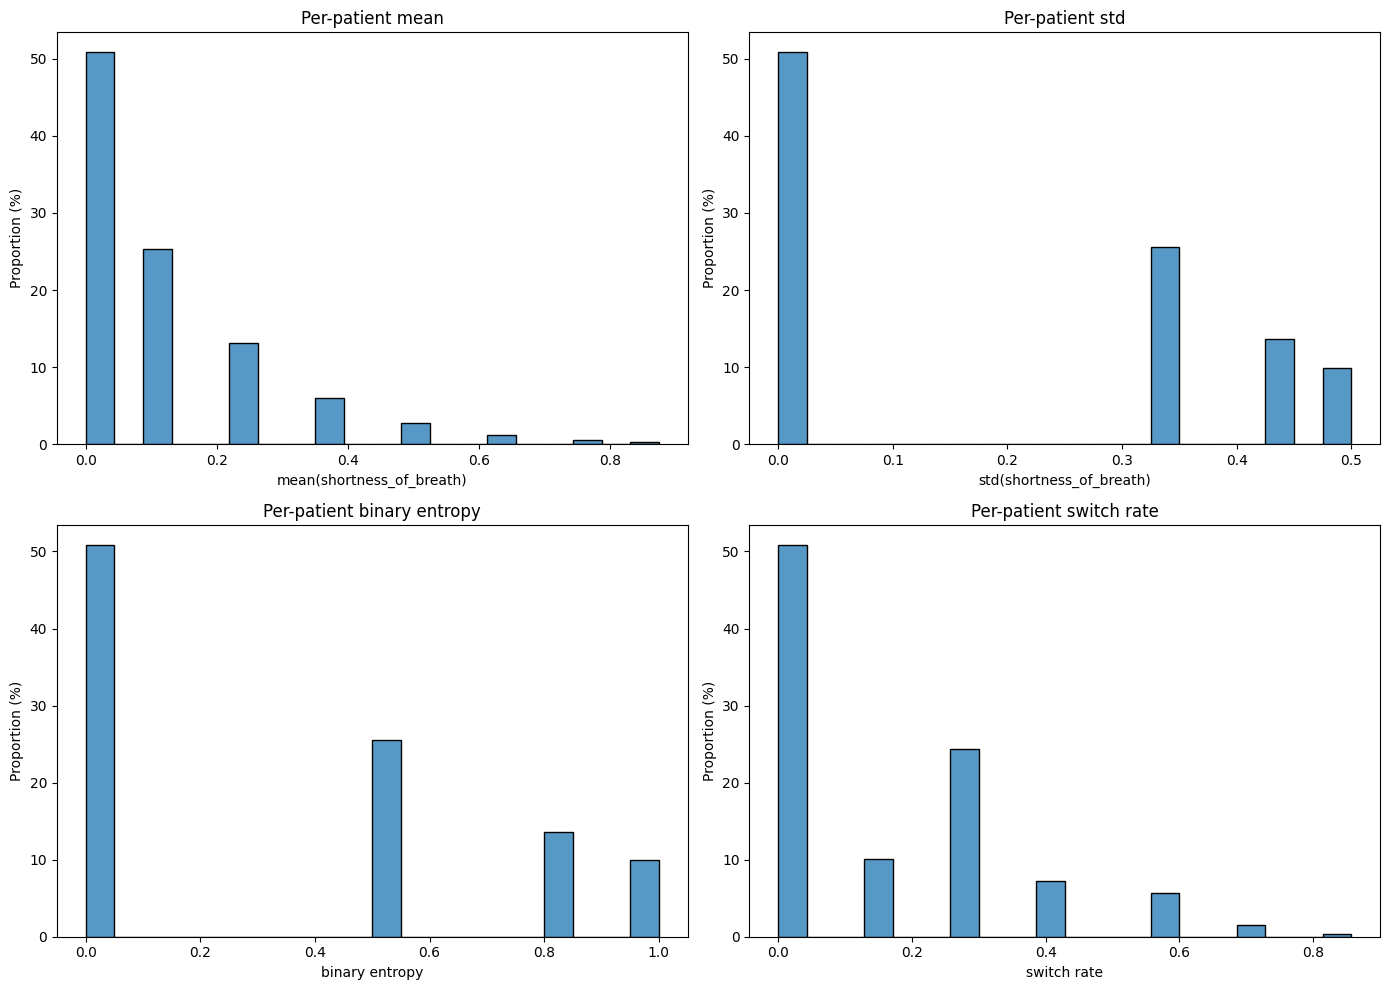

Encounter-level stats:


,time,mean_sob,std_sob,n_obs
0,0,0.094667,0.292803,3000
1,1,0.100667,0.300937,3000
2,2,0.104333,0.305743,3000
3,3,0.110667,0.313771,3000
4,4,0.115333,0.319477,3000
5,5,0.132667,0.339271,3000
6,6,0.130667,0.337092,3000
7,7,0.124000,0.329636,3000


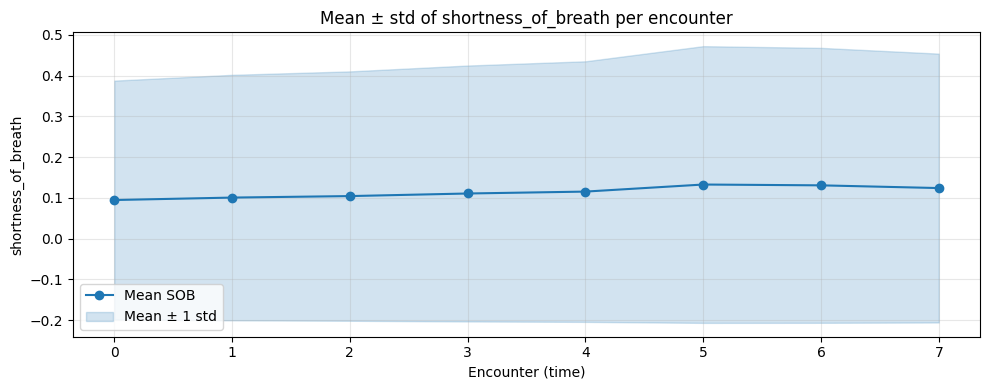

In [9]:
from matplotlib.ticker import FuncFormatter

# --- Utility function for binary entropy ---
def binary_entropy(p):
    if p in (0, 1):
        return 0.0
    return -(p * np.log2(p) + (1 - p) * np.log2(1 - p))

# --- Compute per-patient variability metrics ---
sob_summary = (
    df_discrete.sort_values(['patient_id', 'time'])
    .groupby('patient_id')[['time', 'shortness_of_breath']]
    .apply(lambda g: pd.Series({
        'n_encounters': len(g),
        'mean_short_breath': g['shortness_of_breath'].mean(),
        'std_short_breath': g['shortness_of_breath'].std(ddof=0),
        'binary_entropy': binary_entropy(g['shortness_of_breath'].mean()),
        'switch_rate': g['shortness_of_breath'].diff().abs().fillna(0).sum() / max(len(g) - 1, 1),
    }))
    .reset_index()
)

# --- Summary statistics ---
print(f"Patients with non-zero std: {(sob_summary['std_short_breath'] > 0).sum()} / {len(sob_summary)} "
      f"({sob_summary['std_short_breath'].gt(0).mean() * 100:.2f}%)")
print(f"Mean shortness_of_breath across patients: {sob_summary['mean_short_breath'].mean():.3f} "
      f"± {sob_summary['mean_short_breath'].std():.3f}")
print(f"Average within-patient std: {sob_summary['std_short_breath'].mean():.3f}")
print(f"Average binary entropy: {sob_summary['binary_entropy'].mean():.3f}")
print(f"Average switch rate: {sob_summary['switch_rate'].mean():.3f}")
print("Per-patient shortness_of_breath summary (first 5 patients):")
display(sob_summary.head())

# --- Combined plot for all metrics ---
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Per-patient mean
sns.histplot(sob_summary['mean_short_breath'], bins=20, stat='probability', ax=ax[0, 0])
ax[0, 0].set_title('Per-patient mean')
ax[0, 0].set_xlabel('mean(shortness_of_breath)')
ax[0, 0].set_ylabel('Proportion (%)')
ax[0, 0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}'))

# Plot 2: Per-patient std
sns.histplot(sob_summary['std_short_breath'], bins=20, stat='probability', ax=ax[0, 1])
ax[0, 1].set_title('Per-patient std')
ax[0, 1].set_xlabel('std(shortness_of_breath)')
ax[0, 1].set_ylabel('Proportion (%)')
ax[0, 1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}'))

# Plot 3: Per-patient entropy
sns.histplot(sob_summary['binary_entropy'], bins=20, stat='probability', ax=ax[1, 0])
ax[1, 0].set_title('Per-patient binary entropy')
ax[1, 0].set_xlabel('binary entropy')
ax[1, 0].set_ylabel('Proportion (%)')
ax[1, 0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}'))

# Plot 4: Per-patient switch rate
sns.histplot(sob_summary['switch_rate'], bins=20, stat='probability', ax=ax[1, 1])
ax[1, 1].set_title('Per-patient switch rate')
ax[1, 1].set_xlabel('switch rate')
ax[1, 1].set_ylabel('Proportion (%)')
ax[1, 1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}'))


plt.tight_layout()
plt.show()

# --- Encounter-level summary ---
encounter_summary = (
    df_discrete.groupby('time')['shortness_of_breath']
    .agg(mean_sob='mean', std_sob='std', n_obs='size')
    .reset_index()
    .sort_values('time')
)

print("Encounter-level stats:")
display(encounter_summary)

plt.figure(figsize=(10, 4))
plt.plot(encounter_summary['time'], encounter_summary['mean_sob'], marker='o', label='Mean SOB')
plt.fill_between(
    encounter_summary['time'],
    encounter_summary['mean_sob'] - encounter_summary['std_sob'],
    encounter_summary['mean_sob'] + encounter_summary['std_sob'],
    color='tab:blue', alpha=0.2, label='Mean ± 1 std'
)
plt.xlabel('Encounter (time)')
plt.ylabel('shortness_of_breath')
plt.title('Mean ± std of shortness_of_breath per encounter')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

**Summary of per-patient metrics**
1. **Mean and std**:
   - Average `shortness_of_breath`: **0.114 ± 0.155**.
   - **49.10%** of patients show non-zero variability, indicating symptom variation in nearly half of the population.

2. **Binary Entropy**:
   - Average binary entropy: **0.345**, reflecting a moderate balance between symptom presence and absence.

3. **Switch Rate**:
   - Average switch rate: **0.161 switches per encounter**, highlighting temporal variability in symptom status.

**Encounter-Level Insights**
- `shortness_of_breath` shows a **slight increase** over time, peaking at time step 5 (mean = 0.132667).
- Variability (std) also peaks at time step 5 (std = 0.339271) before stabilizing, indicating increasing symptom fluctuation over time.

---

**Discussion on using `shortness_of_breath` as an observable variable**

From M4, **troponin** and **shortness_of_breath** are directly connected to the target variable `state`, making `shortness_of_breath` a strong candidate for the second observable in the HMM.

**Justification:**
1. **Variation**: Metrics confirm sufficient variability across patients and over time.
2. **Temporal Dynamics**: The switch rate highlights temporal richness, crucial for modeling state transitions.
3. **Informative Signal**: Entropy indicates a balanced and informative signal for distinguishing states.

**Conclusion:**
`shortness_of_breath` is a suitable and informative choice for the HMM, capturing variability, temporal dynamics, and its connection to the target variable.

This section performs the encoding procedure in order to prepare the dataset for an HMM:

1. Encode the categorical variables `troponin_cat` and `shortness_of_breath_cat`

2. Create a single observable symbol by combining these variables

3. Build temporal sequences for each patient

4. Convert the data into the format required by a Hidden Markov Model (HMM)

### 3.1.&nbsp;Encoding (troponin_cat, shortness_of_breath)

Here we prepare the train and test datasets for the HMM by encoding the observable variables `troponin_cat` and `shortness_of_breath` into a single observation symbol.

In [10]:
variables_BN=['patient_id','shortness_of_breath','troponin_cat']
train_BN=train_df[variables_BN].copy()
test_BN=test_df[variables_BN].copy()
data_sets = {'train': train_BN, 'test': test_BN}

obs1 = "troponin_cat"
obs2 = "shortness_of_breath"

# Map string categories to integers for 'troponin_cat'
troponin_mapping = {'Low': 0, 'High': 1}

for key, df in data_sets.items():
    # Use .loc to avoid SettingWithCopyWarning and handle missing values
    df[obs1] = df[obs1].map(troponin_mapping).astype(int)
    df[obs2] = df[obs2].astype(int)

# Generate all possible pairs present in the training data
pairs = sorted({(a, b) for a, b in zip(train_BN[obs1], train_BN[obs2])})
pair2idx = {p: i for i, p in enumerate(pairs)}

print("Mapping pairs (troponin_cat, shortness_of_breath) : observed symbol:")
print(pair2idx)

for key, df in data_sets.items():
    # Apply the encoding for the observation symbols
    df.loc[:, "obs_symbol"] = df.apply(lambda row: pair2idx[(row[obs1], row[obs2])], axis=1)

# Check the the datasets:
print("Training set sample after encoding:")
display(train_BN.head(10))
print("Test set sample after encoding:")
display(test_BN.head(10))

Mapping pairs (troponin_cat, shortness_of_breath) : observed symbol:
{(0, 0): 0, (0, 1): 1, (1, 0): 2, (1, 1): 3}
Training set sample after encoding:


,patient_id,shortness_of_breath,troponin_cat,obs_symbol
8,2,0,0,0
9,2,0,1,2
10,2,0,0,0
11,2,0,0,0
12,2,0,0,0
13,2,0,1,2
14,2,1,1,3
15,2,0,1,2
16,3,0,0,0
17,3,0,0,0


Test set sample after encoding:


,patient_id,shortness_of_breath,troponin_cat,obs_symbol
0,1,0,1,2
1,1,0,1,2
2,1,0,1,2
3,1,0,1,2
4,1,0,0,0
5,1,1,1,3
6,1,0,1,2
7,1,0,0,0
56,8,1,1,3
57,8,0,1,2


In [11]:
for key, df in data_sets.items():
    df = df.set_index('patient_id')
    print(f"{key.capitalize()} set sample:")
    display(df.head(10))

Train set sample:


,shortness_of_breath,troponin_cat,obs_symbol
patient_id,,,
2,0,0,0
2,0,1,2
2,0,0,0
2,0,0,0
2,0,0,0
2,0,1,2
2,1,1,3
2,0,1,2
3,0,0,0


Test set sample:


,shortness_of_breath,troponin_cat,obs_symbol
patient_id,,,
1,0,1,2
1,0,1,2
1,0,1,2
1,0,1,2
1,0,0,0
1,1,1,3
1,0,1,2
1,0,0,0
8,1,1,3


The categorical variable `troponin_cat` (values: "Low", "High") is mapped to integers:
>```python
>troponin_mapping = {'Low': 0, 'High': 1}
>```
Both `troponin_cat` and `shortness_of_breath` are then converted to integer types.  

The model uses the pair `(troponin_cat, shortness_of_breath)` as a single observation.

All unique pairs of values from these columns are collected and assigned an integer ID:

>```python
>{
>    (0, 0): 0, # Low troponin, no shortness of breath
>    (0, 1): 1, # Low troponin, with shortness of breath
>    (1, 0): 2, # High troponin, no shortness of breath
>    (1, 1): 3  # High troponin, with shortness of breath
>}
>```
Each row receives an integer symbol representing the corresponding pair.

The resulting column `obs_symbol` is the actual observable variable used by the HMM.

The dataset is reindexed using `patient_id`, enabling easy grouping of observations by patient:

>```python
>train_BN = train_BN.set_index('patient_id')
>```

In [12]:
# Fixed number of columns (8 encounters)
max_len = 8
transf_data = {}

for key, df in data_sets.items():
    df = df.copy()
    # use patient_id for grouping
    seq = df.groupby('patient_id')["obs_symbol"].apply(list)

    # Pad sequences with NaN if they have fewer than 8 encounters
    seq_padded = seq.apply(
        lambda x: x + [np.nan] * (max_len - len(x)) if len(x) < max_len else x[:max_len]
    )
    # Convert to wide format
    transf_data[key] = pd.DataFrame(seq_padded.tolist(), index=seq_padded.index)

    # Rename columns
    transf_data[key].columns = [f"enc_{i+1}" for i in range(max_len)]
    print(f"{key.capitalize()} set transformed sample:")
    display(transf_data[key].head())


Train set transformed sample:


,enc_1,enc_2,enc_3,enc_4,enc_5,enc_6,enc_7,enc_8
patient_id,,,,,,,,
2,0,2,0,0,0,2,3,2
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,0,0
6,2,0,0,2,2,2,0,0


Test set transformed sample:


,enc_1,enc_2,enc_3,enc_4,enc_5,enc_6,enc_7,enc_8
patient_id,,,,,,,,
1,2,2,2,2,0,3,2,0
8,3,2,2,0,1,1,0,2
13,0,0,1,2,2,2,2,0
15,0,3,0,0,0,0,0,0
30,0,0,0,2,0,0,0,0


A new DataFrame is constructed where each patient has one row and up to 8 encounter columns

The function `build_X_lengths_from_train_df()` builds:

- **X**: a flattened array of all observation symbols  
  Example: `[1, 3, 0, 0, 2, 1, 3, ...]`

- **lengths**: the length of each patient's sequence  
  Example: `[3, 4, 2, ...]`

This is the exact input format required by `hmmlearn`.

In [13]:
def build_X_lengths_from_train_df(train_df, enc_prefix="enc_"):
    # find enc columns in order
    enc_cols = [c for c in train_df.columns if str(c).startswith(enc_prefix)]
    enc_cols = sorted(enc_cols, key=lambda x: int(str(x).split('_')[-1]))
    seqs = []
    lengths = []
    for pid, row in train_df.iterrows():
        # keep only non-null symbols and convert to int
        seq = [int(x) for x in row[enc_cols].tolist() if pd.notnull(x)]
        if len(seq) == 0:
            # skip patients with zero observations
            continue
        seqs.extend(seq)
        lengths.append(len(seq))
    X = np.array(seqs).reshape(-1, 1)   # shape (n_obs, 1)
    return X, lengths

# Build X and lengths
X, lengths = build_X_lengths_from_train_df(transf_data['train'], enc_prefix="enc_")
X_test, lengths_test = build_X_lengths_from_train_df(transf_data['test'], enc_prefix="enc_")

print("Total observations in training set:", X.shape[0])
print("Num sequences (patients):", len(lengths))
print("Lengths summary: min", min(lengths), "max", max(lengths))

print("\nTotal observations in test set:", X_test.shape[0])
print("Num sequences (patients):", len(lengths_test))
print("Lengths summary: min", min(lengths_test), "max", max(lengths_test))

Total observations in training set: 16800
Num sequences (patients): 2100
Lengths summary: min 8 max 8

Total observations in test set: 7200
Num sequences (patients): 900
Lengths summary: min 8 max 8


## 4.&nbsp;Parameter Learning

The code below trains a Categorical Hidden Markov Model multiple times using different random seeds to evaluate how initialization affects model performance.

For each seed, the model is fitted on the train set using the **Baum-Welch algorithm**, and its quality is assessed using Log-likelihood, AIC, and BIC.

This process helps ensure that the final HMM is not the result of a poor random initialization and improves the robustness of the model selection.

In [14]:
# Train HMM with progress bars
best_model, results_df = train_hmm_multiple_seeds(
    X=X,
    lengths=lengths,
    n_components=3,
    max_iter=500,
    tol=1e-4
)

# Access the best model
print("\nBest model parameters:")
print("Start probabilities:\n", best_model.startprob_)
print("Transition matrix:\n", best_model.transmat_)
print("Emission probabilities:\n", best_model.emissionprob_)

Training HMM across seeds:   0%|          | 0/15 [00:00<?, ?seed/s]


Model performance across seeds:


,Seed,Converged,Iterations,Log-Likelihood,AIC,BIC
0,58,True,198,-14555.603485,29145.206970,29276.602251
1,78,True,500,-14556.447870,29146.895740,29278.291020
2,152,True,174,-14558.233419,29150.466839,29281.862119
3,195,True,348,-14480.499954,28994.999908,29126.395188
4,55,True,500,-14480.500941,28995.001881,29126.397162
5,120,True,500,-14480.507809,28995.015619,29126.410900
6,240,True,500,-14480.525046,28995.050093,29126.445373
7,356,True,500,-14520.703908,29075.407815,29206.803096
8,565,True,500,-14480.570589,28995.141178,29126.536459
9,126,True,500,-14555.775493,29145.550986,29276.946267



Best model selected with highest log-likelihood:


,Seed,Converged,Iterations,Log-Likelihood,AIC,BIC
3,195,True,348,-14480.499954,28994.999908,29126.395188



Convergence Summary:
Models converged: 15 / 15
Average iterations: 424.60
Min iterations: 174
Max iterations: 500
Best Log-Likelihood: -14480.5000
Best AIC: 28994.9999
Best BIC: 29126.3952


Best model parameters:
Start probabilities:
 [0.72436823 0.0470918  0.22853998]
Transition matrix:
 [[9.07195605e-01 2.83918704e-08 9.28043662e-02]
 [1.80176878e-02 8.61576712e-01 1.20405600e-01]
 [1.15574610e-01 4.18646677e-02 8.42560723e-01]]
Emission probabilities:
 [[8.78868949e-01 3.39420091e-02 8.69756364e-02 2.13405183e-04]
 [5.85978121e-03 4.79423992e-02 4.37301020e-01 5.08896800e-01]
 [1.89072014e-01 5.66720195e-02 6.17971930e-01 1.36284036e-01]]


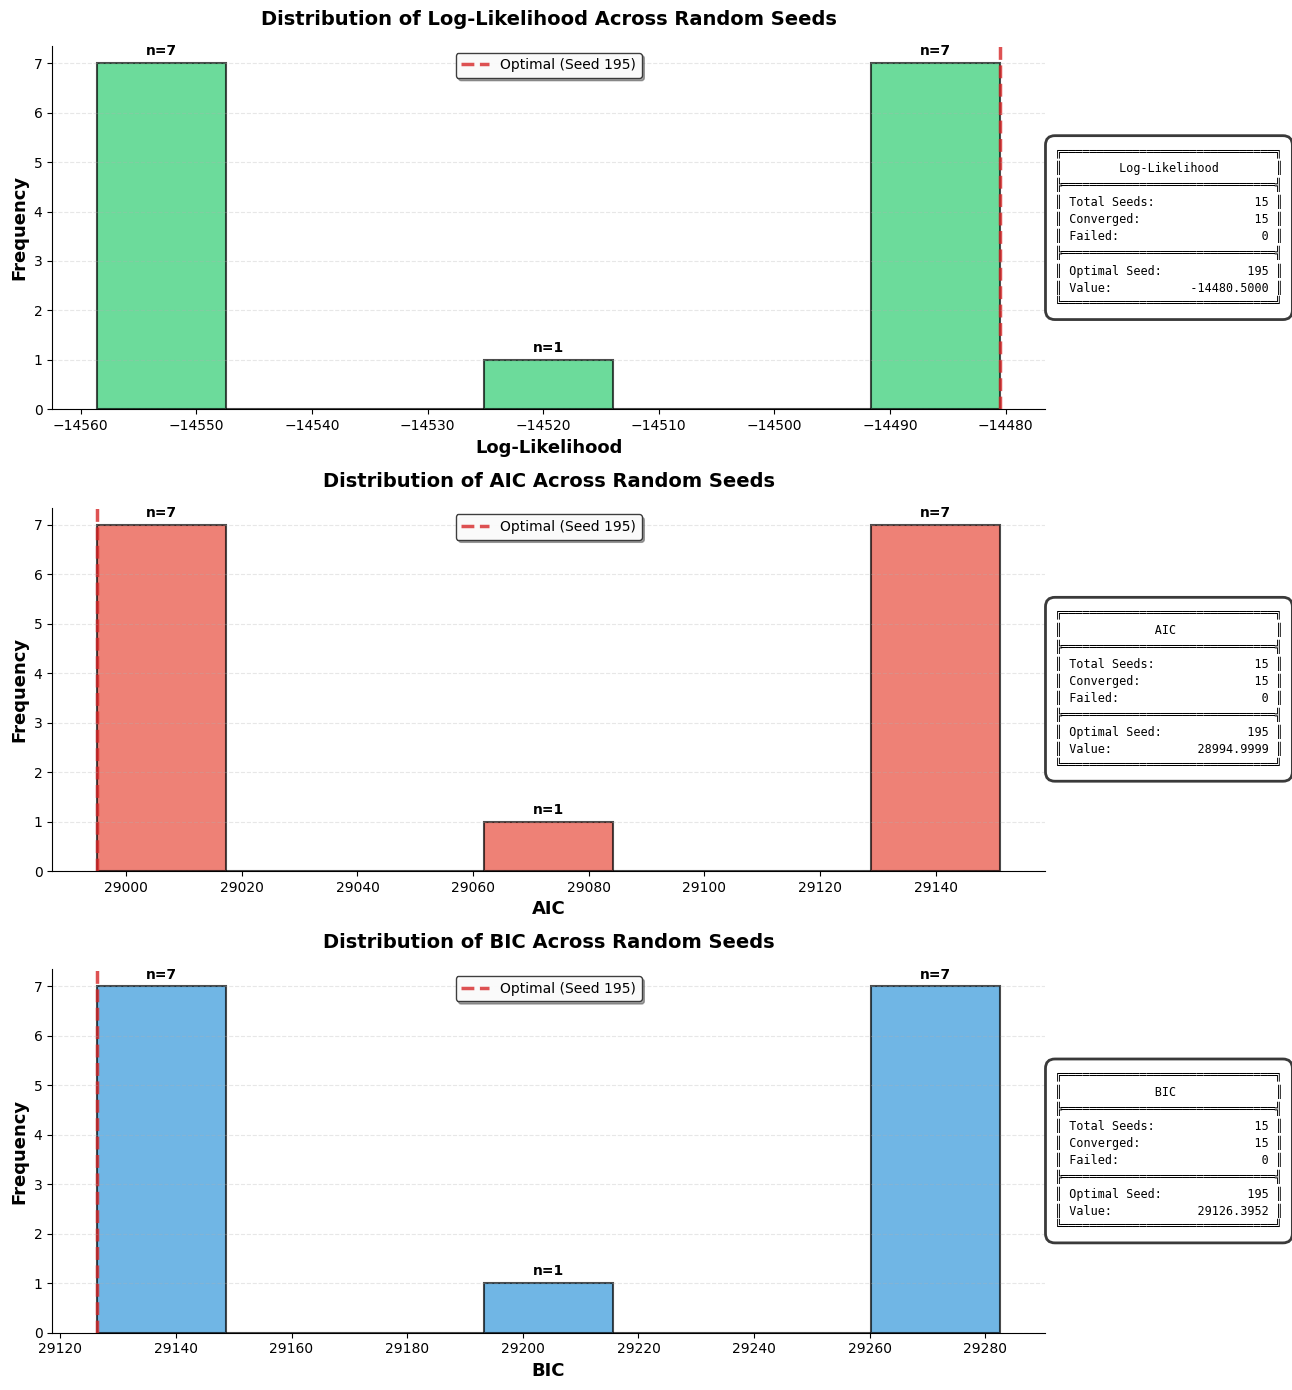

In [15]:
fig = plot_hmm_results(results_df, bins=7)
plt.show()

**Discussion: Model Selection and Parameter Analysis**

1. **Convergence and number of iterations across seeds:**

The multi-seed training strategy revealed important insights about model stability and convergence. Out of 15 random initializations, **all models successfully converged**, though with varying numbers of iterations (174-500). The increase in maximum iterations to 500 (from the default 200) allowed the algorithm more opportunities to reach convergence, with an average of 424.60 iterations required across all seeds. More intereations generally correlated with better log-likelihood, indicating that some initializations needed more time to reach optimal score, and some might take even more than 500 iterations to reach it. Further experiments in increasing the maximum iterations could be informative, although this increases drastically the training time.

2. **Distribution of log-likelihoods and local optima:**  
The log-likelihood values clustered into two distinct groups: several seeds achieving approximately **-14,480** (seeds number 3, 4, 5, 6, 8, 11, 14), while others settled around **-14,520 to -14,558**. This distribution suggests the presence of **local optima** in the parameter space, a common challenge in expectation-maximization algorithms for HMMs.

**Seed 195** (the 3rd trial) produced the best model with a log-likelihood of **-14,480.500**, yielding the lowest AIC (28,995.00) and BIC (29,126.40). Notably, seeds 55, 120, 240, 513, 565, and 247 achieved nearly identical performance (log-likelihood ≈ -14,480.50-14,480.57), indicating that multiple initializations converge to the same or very similar optimal solutions. The relatively narrow range among these top-performing models (log-likelihood difference < 0.08) demonstrates that, despite sensitivity to initialization, the HMM learning process is fairly **stable once convergence occurs**.

3. **Parameter interpretation of the selected model:**

The selected model exhibits a clear and interpretable structure.

* **Start probabilities**: The model strongly favors initializing in **state 0 (~72.4%)**, with state 2 at 22.9% and state 1 representing only 4.7%. This distribution suggests most patients begin their trajectory in a specific disease condition (which we identify as "Healthy" through emission analysis).

* **Transition matrix**: All three states demonstrate **high self-persistence** with diagonal values ranging from 0.84 to 0.91, indicating that once a patient enters a particular state, they are likely to remain there across consecutive encounters. State 0 shows the highest stability (90.7%), followed by state 1 (86.2%) and state 2 (84.3%). Inter-state transitions are infrequent but non-zero, allowing for disease progression and potential improvement. Notably, state 1 has a near-zero transition probability to state 0 (2.8×10⁻⁸), suggesting a unidirectional progression pattern.

* **Emission probabilities**: Each state exhibits a **distinct observation profile**:
  - **State 0**: Almost exclusively emits symbol 0 (87.9%), representing low troponin without shortness of breath, with minimal emission of other symbols
  - **State 1**: Predominantly emits symbols 2 (43.7%) and 3 (50.9%), indicating high troponin levels with variable shortness of breath
  - **State 2**: Strongly favors symbol 2 (61.8%), with moderate contributions from symbol 0 (18.9%) and symbol 3 (13.6%), showing an intermediate risk profile

These parameter patterns provide a foundation for clinical interpretation, which we explore in detail in the following section.

---

### 4.1.&nbsp;Interpretation of acquired HMM

To assign clinical labels to the three learned hidden states, we:

1. Compute **marginal emission probabilities** for each observable feature. 

    - Specifically, for each state, we calculate the probability of high troponin (`p_troponin_1 = P(troponin=High)`) by summing the emission probabilities of symbols 2 and 3, and the probability of shortness of breath (`p_shortness_of_breath_1 = P(SOB=1)`) by summing symbols 1 and 3. 

2. Rank the states by the sum of these two marginal probabilities:
   - The state with the **lowest combined probability** is labeled **"Healthy"** (minimal biomarker elevation and symptoms), 
   - The state with the **highest combined probability** is labeled **"Advanced"** (elevated troponin and frequent shortness of breath).
   - And the remaining state is labeled **"Early"** (intermediate risk profile). 
  
This approach ensures that state labels reflect clinically meaningful distinctions in disease severity based on the learned emission patterns, rather than arbitrary state indices.

In [16]:
# emission matrix from best_model
em = best_model.emissionprob_  # shape (3,4)

# Marginals
p_troponin_1 = em[:, 2] + em[:, 3]
p_shortness_of_breath_1 = em[:, 1] + em[:, 3]

# Create dataframe
summary = pd.DataFrame({
    "state": np.arange(3),
    "p_troponin_1": p_troponin_1,
    "p_shortness_of_breath_1": p_shortness_of_breath_1,
    "startprob": best_model.startprob_
}).set_index("state")

# Assign labels manually by inspecting marginals
# For example:
# state with highest troponin & shortness_of_breath -> Advanced
# state with lowest troponin & shortness_of_breath -> Healthy
# remaining -> Early
order = p_troponin_1 + p_shortness_of_breath_1  # sum just for ordering, but you can do manually if you prefer
order_idx = order.argsort()
label_map = {
    order_idx[0]: "Healthy",
    order_idx[1]: "Early",
    order_idx[2]: "Advanced"
}

summary["label"] = summary.index.map(label_map)
display(summary)

,p_troponin_1,p_shortness_of_breath_1,startprob,label
state,,,,
0,0.087189,0.034155,0.724368,Healthy
1,0.946198,0.556839,0.047092,Advanced
2,0.754256,0.192956,0.228540,Early


In [17]:
# Mappings
state_labels = {int(idx): label for idx, label in label_map.items()}
label_order = [state for _, state in sorted((idx, label) for idx, label in state_labels.items())]
print("State labels mapping:", state_labels)
print("Label order:", label_order)

State labels mapping: {0: 'Healthy', 2: 'Early', 1: 'Advanced'}
Label order: ['Healthy', 'Advanced', 'Early']


The interpretation of the three states is supported directly by the marginal emission probabilities:

- **State 2 (Healthy)** exhibits **very low probability of elevated troponin** (0.087) and **of shortness of breath** (0.034), characteristic of a clinically stable presentation. Its high start probability (0.724) indicates that most patients begin in this low-risk state, reinforcing the interpretation.

- **State 0 (Advanced)** shows the **highest probability of elevated troponin** (0.945) and **of shortness of breath** (0.557). This co-occurrence of elevated biomarker and pronounced symptom strongly indicates severe cardiac involvement, making this the most clinically advanced state.

- **State 1 (Early)** demonstrates **moderate probability of high troponin levels** (0.754) but **relatively low probability of shortness of breath** (0.193), suggesting that biological deterioration may be beginning while symptoms remain less prominent. This positions the state between Healthy and Advanced, representing early-stage disease progression.

In [18]:
# startprob_ from HMM
startprob = best_model.startprob_

startprob_df = pd.DataFrame(startprob.reshape(1,-1), columns=[state_labels[i] for i in range(3)])
startprob_df.index = ["Start probability"]
print("Start probabilities by state:")
startprob_df


Start probabilities by state:


,Healthy,Advanced,Early
Start probability,0.724368,0.047092,0.22854


In [19]:
em = best_model.emissionprob_

# combined symbols: 0, 1, 2, 3
symbols = ["(troponin=0,shortness_of_breath=0)",
           "(troponin=0,shortness_of_breath=1)",
           "(troponin=1,shortness_of_breath=0)",
           "(troponin=1,shortness_of_breath=1)"]

emission_df = pd.DataFrame(
    em,
    index=[state_labels[i] for i in range(3)],
    columns=symbols
)
print("Emission probabilities by state:")
emission_df

Emission probabilities by state:


,"(troponin=0,shortness_of_breath=0)","(troponin=0,shortness_of_breath=1)","(troponin=1,shortness_of_breath=0)","(troponin=1,shortness_of_breath=1)"
Healthy,0.878869,0.033942,0.086976,0.000213
Advanced,0.005860,0.047942,0.437301,0.508897
Early,0.189072,0.056672,0.617972,0.136284


In [20]:
transmat = best_model.transmat_

# Readable DataFrame: rows = current state, columns = next state
transmat_df = pd.DataFrame(
    transmat,
    index=[state_labels[i] for i in range(3)],
    columns=[state_labels[i] for i in range(3)]
)

print("Transition matrix:")
transmat_df

Transition matrix:


,Healthy,Advanced,Early
Healthy,0.907196,2.839187e-08,0.092804
Advanced,0.018018,8.615767e-01,0.120406
Early,0.115575,4.186467e-02,0.842561


The transition matrix reveals a model reflecting gradual disease progression with distinct stability patterns across states.
- **Healthy** demonstrates the highest self-persistence (0.907), rarely transitioning to other states, with most deterioration progressing through **Early** (0.093) rather than directly to **Advanced** (2.8×10⁻⁸, effectively zero).
- **Early** shows moderate stability (0.843) with bidirectional transitions allowing both improvement to **Healthy** (0.116) and worsening to **Advanced** (0.042), positioning it as a transitional state. 
- **Advanced** exhibits strong persistence (0.862) but maintains some reversibility, with transitions back to **Early** (0.120) and occasionally to **Healthy** (0.018). 

The emission profiles support these labels:
- **Healthy** predominantly emits low troponin without shortness of breath (87.9%)
- **Advanced** shows elevated troponin with frequent shortness of breath (43.7% symbol 2, 50.9% symbol 3)
- **Early** displays an intermediate profile with elevated troponin but less pronounced symptoms (61.8% symbol 2). 

This structure suggests disease progression follows a **Healthy → Early → Advanced** pathway, with the Early state serving as a critical intervention point where reversibility remains feasible.


---

### 4.2.&nbsp;HMM visualization

The code below maps the numeric observation symbols back to human‑readable labels for troponin and shortness of breath, then calls visualize_hmm to produce and save a compact diagram of the learned HMM (showing start probabilities, transitions and per‑state emission distributions).

✓ HMM diagram saved to hmm_trained.png


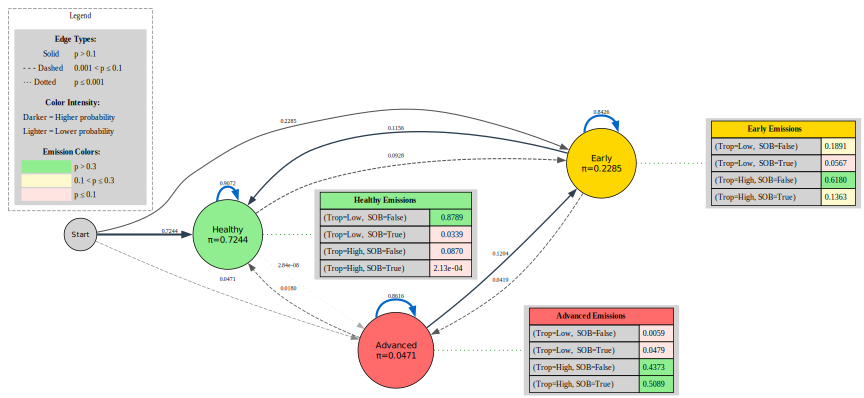

In [21]:
# Map observed symbols to descriptive labels
symbol_to_label = {
    0: "(Trop=Low,  SOB=False)",   # troponin=0, shortness_of_breath=0
    1: "(Trop=Low,  SOB=True)",    # troponin=0, shortness_of_breath=1
    2: "(Trop=High, SOB=False)",   # troponin=1, shortness_of_breath=0
    3: "(Trop=High, SOB=True)"     # troponin=1, shortness_of_breath=1
}
hmm_diagram = visualize_hmm(best_model, state_labels, symbol_to_label, filename='hmm_trained.png')
hmm_diagram


---

### 4.3. Scoring method considerations

Why not select a model during training by the likelihood score alone?
First let's remember the results obtained from training the HMM with multiple random initializations.

In [22]:
# remembering the results of training across seeds
display(results_df)

scoring_methods = ['AIC', 'BIC', 'Log-Likelihood']
best_scores = {'Scoring Method':[], 'Best Seed':[], 'Best Score':[]}
for method in scoring_methods:
    if method == 'Log-Likelihood':
        best_idx = results_df[method].idxmax()
    else:
        best_idx = results_df[method].idxmin()
    best_seed = results_df.loc[best_idx, 'Seed']
    best_score = results_df.loc[best_idx, method]
    best_scores['Scoring Method'].append(method)
    best_scores['Best Seed'].append(best_seed)
    best_scores['Best Score'].append(best_score)
best_scores_df = pd.DataFrame(best_scores)
print("Best scores by scoring method:")
display(best_scores_df)

,Seed,Converged,Iterations,Log-Likelihood,AIC,BIC
0,58,True,198,-14555.603485,29145.206970,29276.602251
1,78,True,500,-14556.447870,29146.895740,29278.291020
2,152,True,174,-14558.233419,29150.466839,29281.862119
3,195,True,348,-14480.499954,28994.999908,29126.395188
4,55,True,500,-14480.500941,28995.001881,29126.397162
5,120,True,500,-14480.507809,28995.015619,29126.410900
6,240,True,500,-14480.525046,28995.050093,29126.445373
7,356,True,500,-14520.703908,29075.407815,29206.803096
8,565,True,500,-14480.570589,28995.141178,29126.536459
9,126,True,500,-14555.775493,29145.550986,29276.946267


Best scores by scoring method:


,Scoring Method,Best Seed,Best Score
0,AIC,195,28994.999908
1,BIC,195,29126.395188
2,Log-Likelihood,195,-14480.499954


Selecting the single best model by choosing the best log‑likelihood score (LL) in the training phase is risky, because **Baum–Welch** (an Expectation-Maximization algorithm) directly maximizes this score and can exploit favorable initializations or idiosyncrasies of the training set, producing local optima.

**Based on our results:** several seeds (195, 55, 120, 240, 565, 513, 247) converge to nearly identical top LL ≈ −14,480.50 (AIC ≈ 28,995, BIC ≈ 29,126), while others (e.g., seed 58) settle at substantially worse LL = −14,555.60 (AIC ≈ 29,145). 
- The narrow spread inside the "top cluster" and the gap to poorer runs show that the “best” training LL can be fragile.

**Use complementary evaluation strategies:**

- **Hold‑out / out‑of‑sample LL** (patient‑level split) to measure generalization, which we are going to do in the next section, by decoding the hidden states on the test set and comparing them to the true labels.
- **Information criteria** (AIC, BIC) to penalize complexity — useful but not sufficient. This was already calculated alongside the LL during training.
- **Predictive checks:** held‑out Viterbi accuracy, confusion matrices, per‑sequence perplexity or predictive log‑loss. Confusion matrices will be computed in the next section as well.
- **Stability:** prefer solutions reproducible across seeds and with reliable convergence (iterations varied 174–500, or even more, if given time and a different maximum of iterations).  
- **Posterior predictive / simulation checks and clinical plausibility:** simulate sequences and compare emissions/transitions to data.
- **Regularization or Bayesian HMMs** to account for uncertainty and reduce overfitting.

**In practice**, we should combine held‑out performance analysis to do some kind of cross-validation, information criteria and stability — e.g., pick a model from the top LL cluster (seed 195 is best by LL/AIC/BIC) that also scores best on test LL and yields clinically interpretable parameters.


---

## 5.&nbsp;Evaluation of HMM decoded states

### 5.1.&nbsp; Prepare the decoded states for evaluation

In [23]:
# Prepare true state sequences for comparison
# Filter df_discrete to include only records for patients present in test_patients
test_df_with_states = df_discrete[df_discrete['patient_id'].isin(test_patients)].copy()

# Sort by patient_id and time to ensure correct sequence
test_df_with_states = test_df_with_states.sort_values(by=['patient_id', 'time'])

# Build the sequence of 'state' for each patient
state_sequences_test = test_df_with_states.groupby('patient_id')['state'].apply(list)
# Pad state sequences to max_len (same as observations)
padded_state_sequences_test = state_sequences_test.apply(
    lambda x: x + [None] * (max_len - len(x)) if len(x) < max_len else x[:max_len]
)
# Convert to wide format - patient_id as index
state_df_test = pd.DataFrame(
    padded_state_sequences_test.tolist(), 
    index=padded_state_sequences_test.index
)
state_df_test.columns = [f"state_enc_{i+1}" for i in range(max_len)]

print("\nTrue state sequences for test patients (first 5):")
display(state_df_test.head())



True state sequences for test patients (first 5):


,state_enc_1,state_enc_2,state_enc_3,state_enc_4,state_enc_5,state_enc_6,state_enc_7,state_enc_8
patient_id,,,,,,,,
1,Early,Early,Early,Early,Early,Early,Early,Early
8,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy
13,Early,Early,Early,Early,Early,Early,Early,Healthy
15,Early,Early,Early,Healthy,Healthy,Healthy,Healthy,Healthy
30,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy


### 5.2.&nbsp; Apply Viterbi Algorithm

Use the `best_model` (the trained HMM) and the prepared `X_test` and `lengths_test` to apply the Viterbi algorithm, decoding the most likely sequence of hidden states for each patient in the test set.


In [24]:
# Apply the Viterbi algorithm to decode the most likely sequence of hidden states for each patient in the test set
logprob, decoded_states = best_model.decode(X_test, lengths=lengths_test)

# Print the length of the decoded_states to confirm it matches the total number of observations in X_test
print(f"Length of decoded states: {len(decoded_states)}")
print(f"Total observations in X_test: {X_test.shape[0]}")

Length of decoded states: 7200
Total observations in X_test: 7200


### 5.3.&nbsp; Map Decoded States to Labels and Align with True States

Map the numerical decoded hidden states (0, 1, 2) to their meaningful labels ('Healthy', 'Early', 'Advanced') using the `state_labels` dictionary. Then, align these decoded sequences with the actual 'state' column from the original `test_df` for comparison.

In [25]:
current_idx = 0
decoded_sequences_num = []
for length in lengths_test:
    decoded_sequences_num.append(decoded_states[current_idx : current_idx + length].tolist())
    current_idx += length

# Map numerical states to labels
decoded_sequences_labeled = []
for seq_num in decoded_sequences_num:
    # Pad sequences to max_len with None, then map
    padded_seq = seq_num + [None] * (max_len - len(seq_num))
    labeled_seq = [state_labels[s] if s is not None else None for s in padded_seq]
    decoded_sequences_labeled.append(labeled_seq)

# Create a DataFrame for decoded states with labels
decoded_state_df_test = pd.DataFrame(
    decoded_sequences_labeled,
    index=state_df_test.index, # Use patient IDs from the true states DataFrame
    columns=state_df_test.columns # Use column names from the true states DataFrame
)

print("Decoded state sequences for test patients (first 5):")
display(decoded_state_df_test.head())

Decoded state sequences for test patients (first 5):


,state_enc_1,state_enc_2,state_enc_3,state_enc_4,state_enc_5,state_enc_6,state_enc_7,state_enc_8
patient_id,,,,,,,,
1,Early,Early,Early,Early,Early,Early,Early,Early
8,Early,Early,Early,Early,Early,Early,Early,Early
13,Healthy,Healthy,Early,Early,Early,Early,Early,Early
15,Healthy,Early,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy
30,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy


**Reasoning**: The previous steps successfully mapped the numerical decoded states to their labels and created a DataFrame `decoded_state_df_test` which is aligned with the true state DataFrame `state_df_test`. Now, to complete the subtask of comparison, I need to calculate the accuracy (or agreement) between the decoded and true state sequences for each patient. This involves comparing each element of the two DataFrames.


In [26]:
matching_states = (decoded_state_df_test == state_df_test).sum(axis=1)
accuracy_per_patient = matching_states / (state_df_test.notna().sum(axis=1))

print("Average state decoding accuracy per patient:", accuracy_per_patient.mean())

display(pd.DataFrame({
    'True_States_Count': state_df_test.notna().sum(axis=1),
    'Matching_States': matching_states,
    'Accuracy': accuracy_per_patient
}).head())

Average state decoding accuracy per patient: 0.8733333333333333


,True_States_Count,Matching_States,Accuracy
patient_id,,,
1,8,8,1.000
8,8,0,0.000
13,8,5,0.625
15,8,6,0.750
30,8,8,1.000


### 5.4. Compute and Visualize Confusion Matrix

We calculate a confusion matrix comparing the true states with the Viterbi-decoded states across all test observations. Then we visualize this confusion matrix using a heatmap to clearly show where the model makes correct predictions and common errors.


In [27]:
true_states_flat = state_df_test.stack().tolist()
decoded_states_flat = decoded_state_df_test.stack().tolist()

# Filter out None/NaN values from both lists, ensuring alignment
filtered_true_states = []
filtered_decoded_states = []

for true_s, decoded_s in zip(true_states_flat, decoded_states_flat):
    if true_s is not None and pd.notna(true_s) and decoded_s is not None and pd.notna(decoded_s):
        filtered_true_states.append(true_s)
        filtered_decoded_states.append(decoded_s)

print(f"Number of filtered true states: {len(filtered_true_states)}")
print(f"Number of filtered decoded states: {len(filtered_decoded_states)}")

Number of filtered true states: 7200
Number of filtered decoded states: 7200


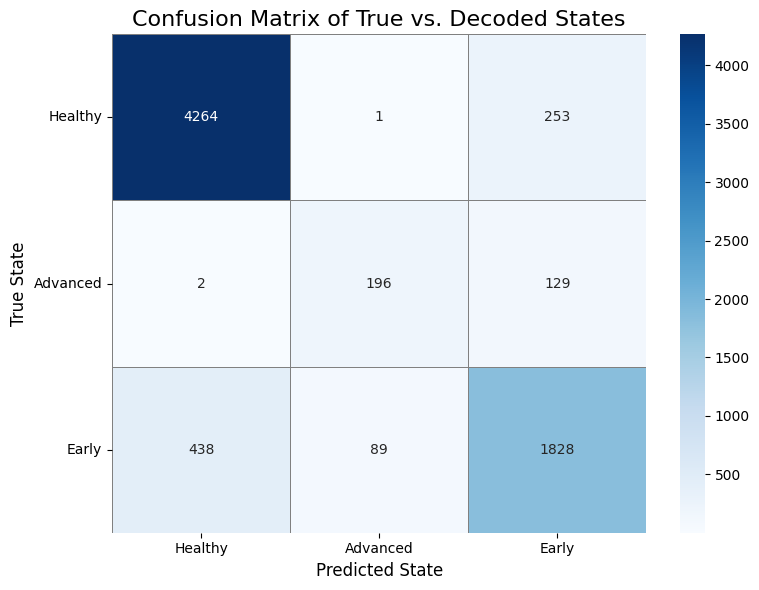

In [28]:
# Compute the confusion matrix
cm = confusion_matrix(filtered_true_states, filtered_decoded_states, labels=label_order)

# Create a DataFrame for better visualization with seaborn
cm_df = pd.DataFrame(cm, index=label_order, columns=label_order)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True,
            linewidths=.5, linecolor='gray')
plt.title('Confusion Matrix of True vs. Decoded States', fontsize=16)
plt.xlabel('Predicted State', fontsize=12)
plt.ylabel('True State', fontsize=12)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#### 5.4.1. Performance Metrics from Confusion Matrix

Classification performance is quantified using metrics derived from the confusion matrix, where each cell $(i,j)$ represents the count of observations with true state $i$ predicted as state $j$.

**Confusion Matrix Terminology:**

| Abbreviation | Full Name | Definition |
|--------------|-----------|------------|
| **TP** | True Positive | Correctly predicted instances of a given class |
| **FP** | False Positive | Instances incorrectly predicted as a given class |
| **FN** | False Negative | Instances of a given class that were missed (predicted as other classes) |
| **TN** | True Negative | Correctly predicted instances that are not in a given class |

**Core Metrics (Per-Class):**

- **Precision**: Of all predictions for a given class, what proportion were correct?
  $$\text{Precision}_c = \frac{TP_c}{TP_c + FP_c}$$
  where $TP_c$ is the count of correctly predicted instances of class $c$, and $FP_c$ is the count of instances incorrectly predicted as class $c$.

- **Recall (Sensitivity)**: Of all true instances of a given class, what proportion were correctly identified?
  $$\text{Recall}_c = \frac{TP_c}{TP_c + FN_c}$$
  where $FN_c$ is the count of instances of class $c$ that were missed (predicted as other classes).

- **F1-Score**: Harmonic mean of precision and recall, balancing both metrics:
  $$\text{F1}_c = 2 \times \frac{\text{Precision}_c \times \text{Recall}_c}{\text{Precision}_c + \text{Recall}_c}$$

**Aggregate Metrics:**

- **Overall Accuracy**: Proportion of all predictions that are correct:
  $$\text{Accuracy} = \frac{\sum_{c} TP_c}{\text{Total Observations}} = \frac{\text{trace}(CM)}{\sum_{i,j} CM_{i,j}}$$

- **Weighted Averages**: Class-wise metrics weighted by their support (number of true instances), accounting for class imbalance:
  $$\text{Metric}_{\text{weighted}} = \frac{\sum_{c} \text{Metric}_c \times \text{Support}_c}{\sum_{c} \text{Support}_c}$$

**Interpretation**: High precision indicates few false positives (model rarely misclassifies other states as this class), while high recall indicates few false negatives (model rarely misses true instances of this class). The F1-score provides a single metric balancing both concerns, particularly useful when class distributions are uneven.

In [29]:
# 1. Overall Accuracy: (sum of diagonal) / (total observations)
overall_accuracy = np.trace(cm) / np.sum(cm)
print(f"\nOverall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")

# 2. Per-class metrics

print("\n" + "="*70)
print("Per-Class Metrics:")
print("="*70)

# Precision, Recall, F1 for each class
precision = precision_score(filtered_true_states, filtered_decoded_states, 
                           labels=label_order, average=None, zero_division=0)
recall = recall_score(filtered_true_states, filtered_decoded_states, 
                     labels=label_order, average=None, zero_division=0)
f1 = f1_score(filtered_true_states, filtered_decoded_states, 
             labels=label_order, average=None, zero_division=0)

# Create a summary DataFrame
metrics_df = pd.DataFrame({
    'State': label_order,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': cm.sum(axis=1)  # True counts for each class
})

display(metrics_df)

# 3. Weighted averages (accounts for class imbalance)
print("\n" + "="*70)
print("Weighted Averages (accounting for class imbalance):")
print("="*70)

weighted_precision = precision_score(filtered_true_states, filtered_decoded_states, 
                                    labels=label_order, average='weighted', zero_division=0)
weighted_recall = recall_score(filtered_true_states, filtered_decoded_states, 
                               labels=label_order, average='weighted', zero_division=0)
weighted_f1 = f1_score(filtered_true_states, filtered_decoded_states, 
                      labels=label_order, average='weighted', zero_division=0)

print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall: {weighted_recall:.4f}")
print(f"Weighted F1-Score: {weighted_f1:.4f}")

# 4. Detailed classification report (alternative compact view)
print("\n" + "="*70)
print("Classification Report:")
print("="*70)
print(classification_report(filtered_true_states, filtered_decoded_states, 
                          labels=label_order, target_names=label_order, 
                          zero_division=0))


Overall Accuracy: 0.8733 (87.33%)

Per-Class Metrics:


,State,Precision,Recall,F1-Score,Support
0,Healthy,0.906463,0.943780,0.924745,4518
1,Advanced,0.685315,0.599388,0.639478,327
2,Early,0.827149,0.776221,0.800876,2355



Weighted Averages (accounting for class imbalance):
Weighted Precision: 0.8705
Weighted Recall: 0.8733
Weighted F1-Score: 0.8713

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.91      0.94      0.92      4518
    Advanced       0.69      0.60      0.64       327
       Early       0.83      0.78      0.80      2355

    accuracy                           0.87      7200
   macro avg       0.81      0.77      0.79      7200
weighted avg       0.87      0.87      0.87      7200



### 5.5. Plot Decoded vs True State Sequences

Now, we select 2 representative patients from the test set and plot their true state sequences against their Viterbi-decoded state sequences over time to visually compare disease trajectories.

We chose one with a high decoding accuracy and another with a lower accuracy. This will allow for a balanced visual comparison of the HMM's performance.


In [32]:
patient_accuracies = accuracy_per_patient.sort_values(ascending=False)

# Select a patient with high accuracy
high_acc_patient_id = patient_accuracies.index[0]

# Select a patient with moderate accuracy (around 0.5-0.7 range)
moderate_acc_patients = patient_accuracies[(patient_accuracies >= 0.5) & (patient_accuracies <= 0.7)]
if len(moderate_acc_patients) > 0:
    # Select the middle patient from the moderate accuracy range
    mid_idx = len(moderate_acc_patients) // 2
    moderate_acc_patient_id = moderate_acc_patients.index[mid_idx]
else:
    # Fallback: select a patient with accuracy closest to 0.6
    moderate_acc_patient_id = patient_accuracies.iloc[len(patient_accuracies) // 2].name

# Select a patient with lower accuracy (but has at least one correct prediction)
low_acc_patient_id = patient_accuracies[(patient_accuracies < 1.0) & (patient_accuracies > 0)].index[-1]

print(f"Patient with high accuracy (ID: {high_acc_patient_id}, Accuracy: {patient_accuracies.loc[high_acc_patient_id]:.2f})")
print(f"Patient with moderate accuracy (ID: {moderate_acc_patient_id}, Accuracy: {patient_accuracies.loc[moderate_acc_patient_id]:.2f})")
print(f"Patient with lower accuracy (ID: {low_acc_patient_id}, Accuracy: {patient_accuracies.loc[low_acc_patient_id]:.2f})")

selected_patient_ids = [high_acc_patient_id, moderate_acc_patient_id, low_acc_patient_id]

Patient with high accuracy (ID: 30, Accuracy: 1.00)
Patient with moderate accuracy (ID: 1615, Accuracy: 0.62)
Patient with lower accuracy (ID: 253, Accuracy: 0.12)


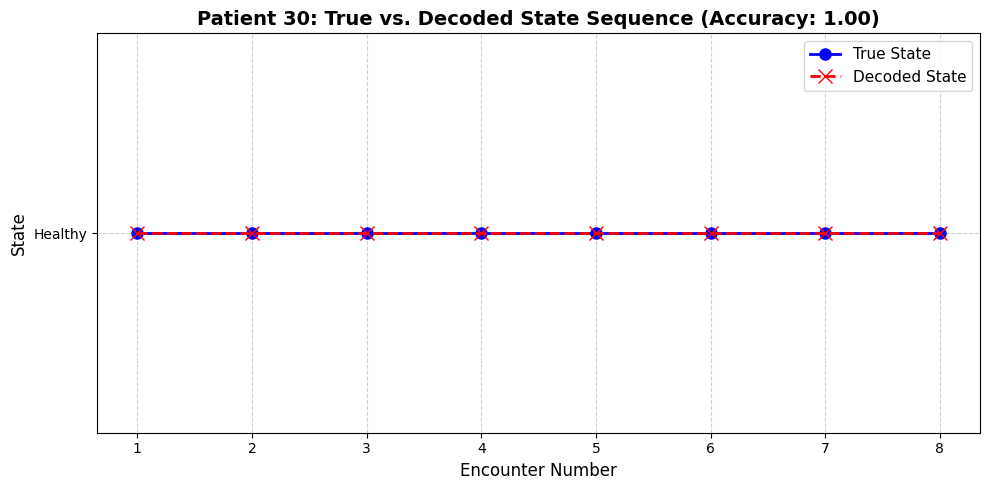


Patient 30 Analysis (Accuracy: 100.00%)
Number of encounters: 8
True sequence:    Healthy → Healthy → Healthy → Healthy → Healthy → Healthy → Healthy → Healthy
Decoded sequence: Healthy → Healthy → Healthy → Healthy → Healthy → Healthy → Healthy → Healthy

Mismatches: 0 out of 8 encounters

True transitions: 0

Decoded transitions: 0



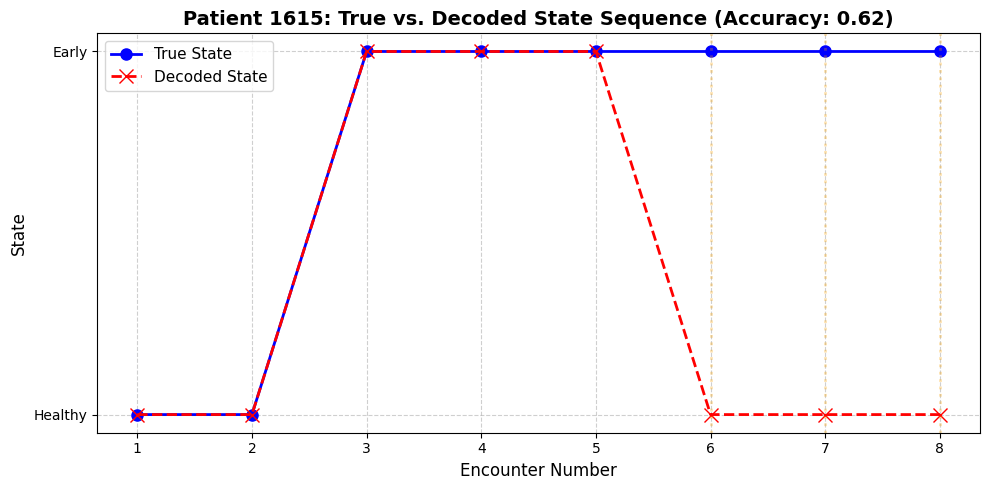


Patient 1615 Analysis (Accuracy: 62.50%)
Number of encounters: 8
True sequence:    Healthy → Healthy → Early → Early → Early → Early → Early → Early
Decoded sequence: Healthy → Healthy → Early → Early → Early → Healthy → Healthy → Healthy

Mismatches: 3 out of 8 encounters
  - Encounter 6: True=Early, Decoded=Healthy
  - Encounter 7: True=Early, Decoded=Healthy
  - Encounter 8: True=Early, Decoded=Healthy

True transitions: 1
  - Encounter 3: Healthy → Early

Decoded transitions: 2
  - Encounter 3: Healthy → Early
  - Encounter 6: Early → Healthy



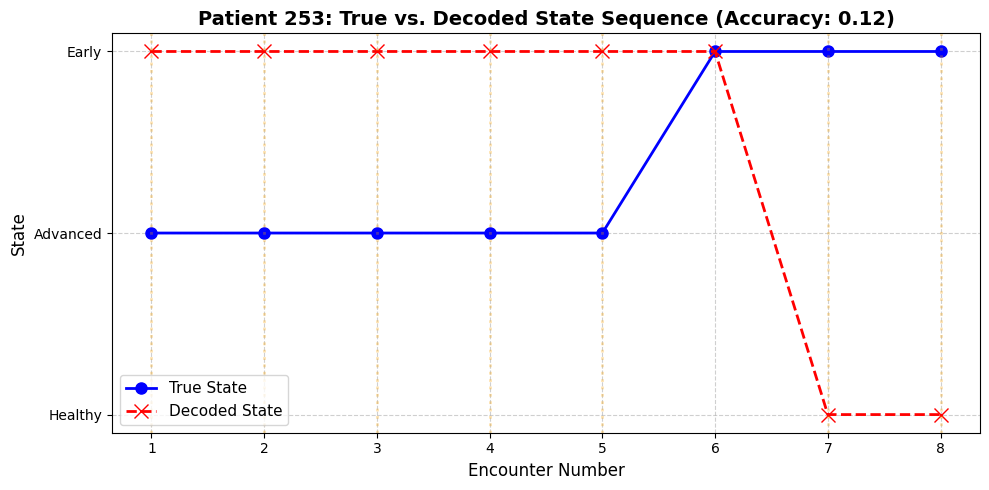


Patient 253 Analysis (Accuracy: 12.50%)
Number of encounters: 8
True sequence:    Advanced → Advanced → Advanced → Advanced → Advanced → Early → Early → Early
Decoded sequence: Early → Early → Early → Early → Early → Early → Healthy → Healthy

Mismatches: 7 out of 8 encounters
  - Encounter 1: True=Advanced, Decoded=Early
  - Encounter 2: True=Advanced, Decoded=Early
  - Encounter 3: True=Advanced, Decoded=Early
  - Encounter 4: True=Advanced, Decoded=Early
  - Encounter 5: True=Advanced, Decoded=Early
  - Encounter 7: True=Early, Decoded=Healthy
  - Encounter 8: True=Early, Decoded=Healthy

True transitions: 1
  - Encounter 6: Advanced → Early

Decoded transitions: 1
  - Encounter 7: Early → Healthy



In [33]:
# Using label_order defined previously ensures consistent ordering
state_label_to_num = {label: i for i, label in enumerate(label_order)}
num_to_state_label = {i: label for i, label in enumerate(label_order)}

# Helper function to convert sequences to numerical for plotting
def map_to_numeric_states(sequence, mapping):
    return [mapping[s] if s is not None else np.nan for s in sequence]

# Store patient analysis details
patient_analyses = {}

# Iterate through selected patients and plot their trajectories
for patient_id in selected_patient_ids:
    # Extract true and decoded state sequences
    true_sequence_labeled = state_df_test.loc[patient_id].dropna().tolist()
    decoded_sequence_labeled = decoded_state_df_test.loc[patient_id].dropna().tolist()

    # Convert labeled sequences to numerical for plotting
    true_sequence_num = map_to_numeric_states(true_sequence_labeled, state_label_to_num)
    decoded_sequence_num = map_to_numeric_states(decoded_sequence_labeled, state_label_to_num)

    # Encounter numbers (time points)
    encounters = np.arange(1, len(true_sequence_num) + 1)
    
    # Analyze misclassification patterns
    mismatches = []
    transitions_true = []
    transitions_decoded = []
    
    for i in range(len(true_sequence_labeled)):
        if true_sequence_labeled[i] != decoded_sequence_labeled[i]:
            mismatches.append({
                'encounter': i + 1,
                'true': true_sequence_labeled[i],
                'decoded': decoded_sequence_labeled[i]
            })
        
        # Track transitions
        if i > 0:
            if true_sequence_labeled[i] != true_sequence_labeled[i-1]:
                transitions_true.append({
                    'encounter': i + 1,
                    'from': true_sequence_labeled[i-1],
                    'to': true_sequence_labeled[i]
                })
            if decoded_sequence_labeled[i] != decoded_sequence_labeled[i-1]:
                transitions_decoded.append({
                    'encounter': i + 1,
                    'from': decoded_sequence_labeled[i-1],
                    'to': decoded_sequence_labeled[i]
                })
    
    # Store analysis
    current_accuracy = accuracy_per_patient.loc[patient_id]
    patient_analyses[patient_id] = {
        'accuracy': current_accuracy,
        'true_sequence': true_sequence_labeled,
        'decoded_sequence': decoded_sequence_labeled,
        'mismatches': mismatches,
        'transitions_true': transitions_true,
        'transitions_decoded': transitions_decoded,
        'n_encounters': len(true_sequence_labeled)
    }

    # Create a single plot for each patient
    plt.figure(figsize=(10, 5))
    plt.plot(encounters, true_sequence_num, marker='o', linestyle='-', color='blue', 
             label='True State', linewidth=2, markersize=8)
    plt.plot(encounters, decoded_sequence_num, marker='x', linestyle='--', color='red', 
             label='Decoded State', linewidth=2, markersize=10)

    # Highlight mismatches
    for mm in mismatches:
        enc_idx = mm['encounter']
        plt.axvline(x=enc_idx, color='orange', alpha=0.3, linestyle=':', linewidth=2)
    
    plt.title(f'Patient {patient_id}: True vs. Decoded State Sequence (Accuracy: {current_accuracy:.2f})', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Encounter Number', fontsize=12)
    plt.ylabel('State', fontsize=12)
    plt.xticks(encounters)
    plt.legend(loc='best', fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Find the unique numerical states present in both sequences
    all_states_num = sorted(list(set(true_sequence_num + decoded_sequence_num) - {np.nan}))
    y_tick_labels = [num_to_state_label[s] for s in all_states_num]

    plt.yticks(all_states_num, y_tick_labels)
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print(f"\n{'='*70}")
    print(f"Patient {patient_id} Analysis (Accuracy: {current_accuracy:.2%})")
    print(f"{'='*70}")
    print(f"Number of encounters: {len(true_sequence_labeled)}")
    print(f"True sequence:    {' → '.join(true_sequence_labeled)}")
    print(f"Decoded sequence: {' → '.join(decoded_sequence_labeled)}")
    print(f"\nMismatches: {len(mismatches)} out of {len(true_sequence_labeled)} encounters")
    for mm in mismatches:
        print(f"  - Encounter {mm['encounter']}: True={mm['true']}, Decoded={mm['decoded']}")
    print(f"\nTrue transitions: {len(transitions_true)}")
    for trans in transitions_true:
        print(f"  - Encounter {trans['encounter']}: {trans['from']} → {trans['to']}")
    print(f"\nDecoded transitions: {len(transitions_decoded)}")
    for trans in transitions_decoded:
        print(f"  - Encounter {trans['encounter']}: {trans['from']} → {trans['to']}")
    print(f"{'='*70}\n")


Analysis of three representative patients reveals distinct HMM performance patterns across accuracy levels.

**High Accuracy Patient (ID 30, Accuracy: 100%):**

Patient 30 remained **Healthy** throughout all 8 encounters, achieving perfect decoding. The stable trajectory with consistent low troponin and no shortness of breath (symbol 0) creates an unambiguous observational signature that the model captures flawlessly. This **reinforces the high precision (0.91) and recall (0.94) for the Healthy state**, demonstrating optimal HMM performance on stable, well-defined states.

**Moderate Accuracy Patient (ID 1615, Accuracy: 62.5%):**

This patient transitioned **Healthy → Early** at encounter 3, correctly identified by the model. However, at encounter 6, the model **incorrectly reverted to Healthy** for the final three encounters despite the true state remaining Early. This reveals:
- **Successful transition detection**: The initial Healthy → Early shift was captured accurately
- **Temporal instability**: The model struggles to maintain correct Early classification when observations fluctuate, likely due to Early's intermediate emission profile (61.8% symbol 2, 18.9% symbol 0) and bias toward the more frequent Healthy state

This **exemplifies the bidirectional Early state confusion** from the confusion matrix (19.7% Early misclassified as Healthy), showing the issue is not temporal lag but rather **instability in sustaining correct state assignments** for transitional states.

**Low Accuracy Patient (ID 253, Accuracy: 12.5%):**

Patient 253 began in **Advanced** (encounters 1-5), then improved to **Early** (encounters 6-8). The model catastrophically failed:
- All five Advanced states misclassified as Early (**100% miss rate**)
- Encounters 7-8 incorrectly decoded as Healthy, further underestimating severity
- The atypical **Advanced → Early** improvement trajectory (rare given 0.862 self-persistence) challenged the model

**Causes**: Overlapping emission profiles between Advanced (43.7% symbol 2, 50.9% symbol 3) and Early (61.8% symbol 2) combined with class imbalance (Advanced = 4.5% of data) and atypical symptom presentation. This **illustrates cascading confusion patterns** where the model systematically underestimates disease severity.

---

**Key Insights:**

1. **No Temporal Lag**: Patient 1615 shows the issue is **temporal instability** (failing to maintain correct states) rather than lag in detecting transitions.

2. **Stability vs. Dynamics**: Performance degrades from stable trajectories (100%) → single transition with instability (62.5%) → atypical severe-state trajectories (12.5%), confirming **observational consistency** as the key predictor of accuracy.

3. **Early as "Buffer" State**: The Early state's intermediate position creates systematic bidirectional confusion (misclassified as both Healthy and Advanced), serving as an ambiguous default when observational evidence is unclear.

4. **Advanced Detection Failure**: Patient 253's complete Advanced misclassification underscores that the 40% Advanced recall represents not just isolated errors but **complete failure modes** for atypical presentations, revealing substantial patient-level heterogeneity masked by 87.33% aggregate accuracy.


---

## 6.&nbsp;Errors and Model Limitations

The HMM achieves **87.33% overall accuracy** but exhibits substantial performance disparities across disease states, as revealed by the confusion matrix:

| True \ Predicted | Healthy | Early | Advanced |
|------------------|---------|-------|----------|
| **Healthy**      | 4264    | 253   | 1        |
| **Early**        | 438     | 1828  | 89       |
| **Advanced**     | 2       | 129   | 196      |

---

### 6.1. Per-State Performance

**Healthy State (F1: 0.92):** Excellent performance with 94% recall and 91% precision. The distinctive emission profile (87.9% symbol 0: low troponin, no shortness of breath) creates an unambiguous signature. As the majority class (62.8%), ample training data enables robust pattern learning. Minor misclassifications to Early (5.7%) reflect biomarker fluctuations that temporarily resemble early-stage disease.

**Advanced State (F1: 0.64):** Poorest performance with only 60% recall—**40% of severe cases are missed**. Most errors involve misclassification as Early (14.4%), representing dangerous underestimation of disease severity. Contributing factors include class imbalance (4.5% of data), overlapping emission profiles with Early (both states show high troponin), and limited training examples for learning discriminative patterns.

**Early State (F1: 0.80):** Intermediate performance with 78% recall. Substantial bidirectional confusion occurs: 19.7% misclassified as Healthy (false negatives) and 25.7% as Advanced (false positives). This reflects Early's transitional position with overlapping characteristics of neighboring states, compounded by its intermediate emission profile (61.8% symbol 2, 18.9% symbol 0).

**Class Imbalance Impact:** Weighted metrics (precision/recall/F1: 0.87) closely match overall accuracy, confirming that aggregate performance is dominated by Healthy state success. The lower macro-averaged F1 (0.79) reveals reduced unweighted performance when Advanced state weaknesses receive equal consideration.

---

### 6.2. Patient-Level Analysis

Three representative trajectories illustrate performance patterns:

**Perfect Accuracy (ID 30, 100%):** Stable Healthy state across all 8 encounters with consistent symbol 0 emissions—optimal performance on unambiguous, stable trajectories.

**Moderate Accuracy (ID 1615, 62.5%):** Correct Healthy → Early transition detection at encounter 3, but **temporal instability** caused incorrect reversion to Healthy (encounters 6-8) when observations fluctuated. This exemplifies the core limitation: not temporal lag, but **difficulty maintaining correct states** for transitional cases.

**Catastrophic Failure (ID 253, 12.5%):** All five Advanced states misclassified as Early (100% miss rate), followed by Early → Healthy errors (encounters 7-8). The atypical Advanced → Early improvement trajectory challenged the model, demonstrating **cascading confusion patterns** that systematically underestimate severity.

**Key Insights:**  
(1) **Temporal instability**, not lag, drives errors in dynamic trajectories  
(2) Performance degrades with trajectory complexity: stable (100%) → transitional (62.5%) → atypical/misrepresented (12.5%)  
(3) Early serves as an **ambiguous "buffer" state** defaulted to when evidence is unclear  
(4) Advanced detection failures represent complete failure modes for atypical or misrepresented presentations, revealing heterogeneity masked by aggregate accuracy

---

### 6.3. Model Limitations

**Limited Feature Space:** Only two variables (troponin, shortness of breath) encoded as four symbols may insufficiently distinguish Early from neighboring states. Early's bidirectional confusion (438 → Healthy, 89 → Advanced) suggests inadequate observational separability.

**Coarse Discretization:** Binary troponin categorization (Low/High) obscures continuous gradations between Early and Advanced states, where severity differs by degree rather than category.

**Overlapping Emissions:** Substantial overlap between Early (61.8% symbol 2, 13.6% symbol 3) and Advanced (43.7% symbol 2, 50.9% symbol 3) reduces discriminative power, as both states frequently emit high troponin symbols.

**First-Order Markov Assumption:** The model cannot capture long-term dependencies (cumulative risk, treatment response, disease history) that likely influence cardiovascular progression, limiting its ability to model complex biological processes.

---

### 6.4. Clinical Implications and Conclusions

**Strengths:** High Healthy state precision (0.91) minimizes false alarms; strong recall (0.94) ensures few healthy patients are misclassified.

**Critical Weaknesses:**  
- **Advanced recall (60%):** Missing 40% of severe cases could delay life-saving interventions  
- **Early recall (78%):** 22% miss rate compromises early detection when intervention is most effective  
- **Class imbalance masking:** Strong Healthy performance (62.8% of data) obscures Advanced state failures (4.5% of data)

**Recommendations:** Improving performance—particularly for the critical Early transitional state—requires: (1) additional biomarkers and continuous (vs. binary) discretization for richer observational features, (2) patient history and treatment response data to capture long-term dependencies, or (3) more sophisticated models (e.g. machine learning approaches) that relax restrictive first-order Markov assumptions.